In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/delve_source_3/delve_source_3.npy'
target_img_path = head / 'data/delve_target_3/delve_target_3.npy'
source_meta = head / 'data/delve_source_3/delve_source_3_metadata.csv'
target_meta = head / 'data/delve_target_3/delve_target_3_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

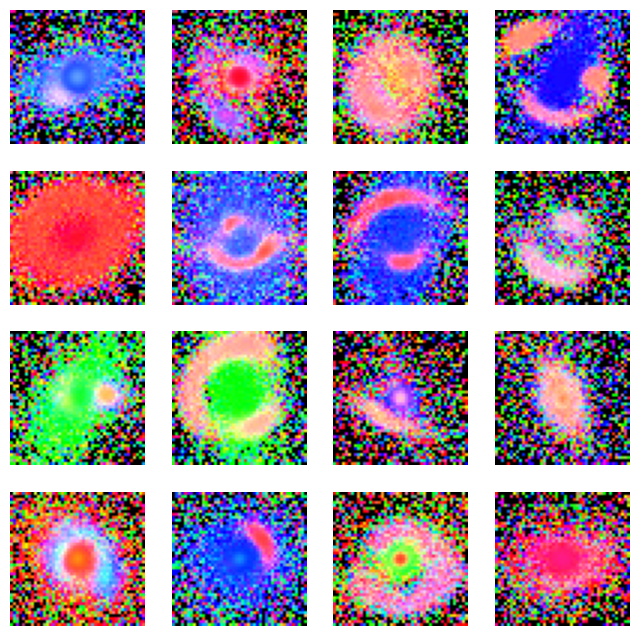

In [3]:
# Visualize source data
visualize_data(source_data)

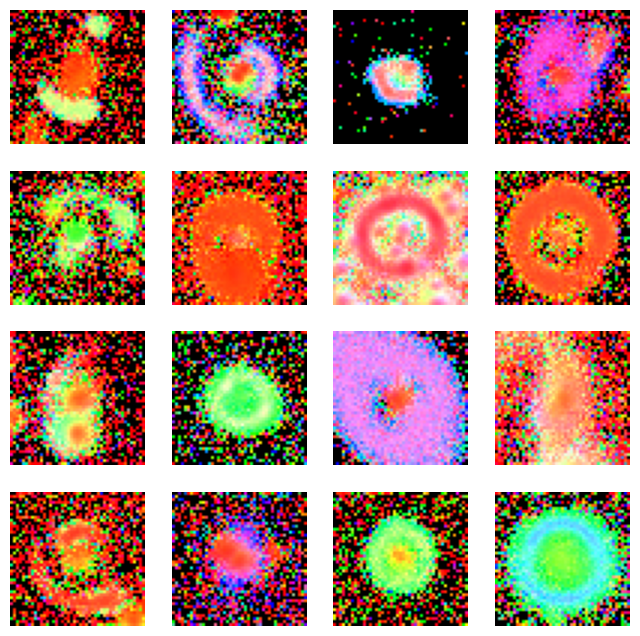

In [4]:
# Visualize target data
visualize_data(target_data)

from matplotlib.colors import PowerNorm

plt.imshow(source_data[212, 0, :, :], norm = PowerNorm(0.5), cmap = 'inferno')
plt.colorbar()

plt.imshow(target_data[2990, 0, :, :], norm = PowerNorm(0.5), cmap = 'inferno')
plt.colorbar()

source_metatab = pd.read_csv(source_meta)
target_metatab = pd.read_csv(target_meta)

source_metatab.iloc[86, 30:60]

b = 10#np.linspace(0, 1, 20)
plt.hist(source_metatab['PLANE_2-OBJECT_1-MASS_PROFILE_1-sigma_v-g'], bins = b)
plt.hist(target_metatab['PLANE_2-OBJECT_1-MASS_PROFILE_1-sigma_v-g'], bins = b, alpha = 0.5)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Parameters for the lognormal distribution
shape = 1.6  # Shape parameter (sigma)
scale = np.exp(0)  # Scale parameter (exp(mu))
size = 10000  # Number of samples

# Generate random samples from the lognormal distribution
samples = lognorm.rvs(s=shape, scale=scale, size=size)

# Plot the histogram of the samples
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')

# Plot the theoretical lognormal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = lognorm.pdf(x, s=shape, scale=scale)
plt.plot(x, p, 'k', linewidth=2)

title = f"Fit results: shape = {shape}, scale = {scale}"
plt.title(title)

plt.show()

In [5]:
model = NeuralNetwork(npix=45).cuda()
learning_rate = 1e-5
epochs = 100
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()

# Try to adjust momentum -> see if that helps
# Try SGD, Adadelta, see if that helps
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

In [6]:
mod_name = None#"models/mb_lenscolor_jul25_1700" #
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[],
            'epoch_no': 0}
if mod_name is not None:
    state = torch.load(mod_name)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    
    stat_file = Path(mod_name+'.json')
    if stat_file.is_file():
        stats = json.load(open(mod_name+'.json', 'r'))

Beginning Training...
Generating Isomap...


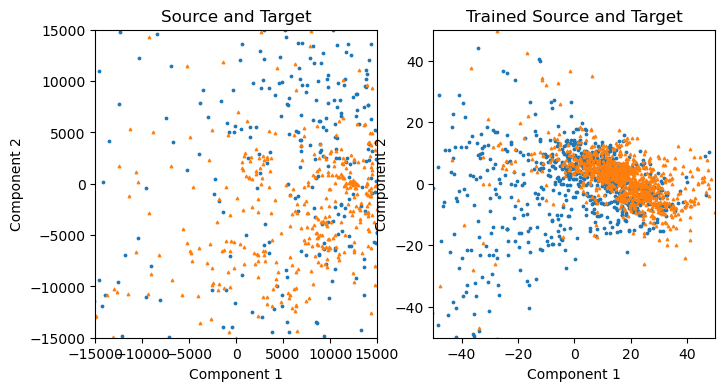

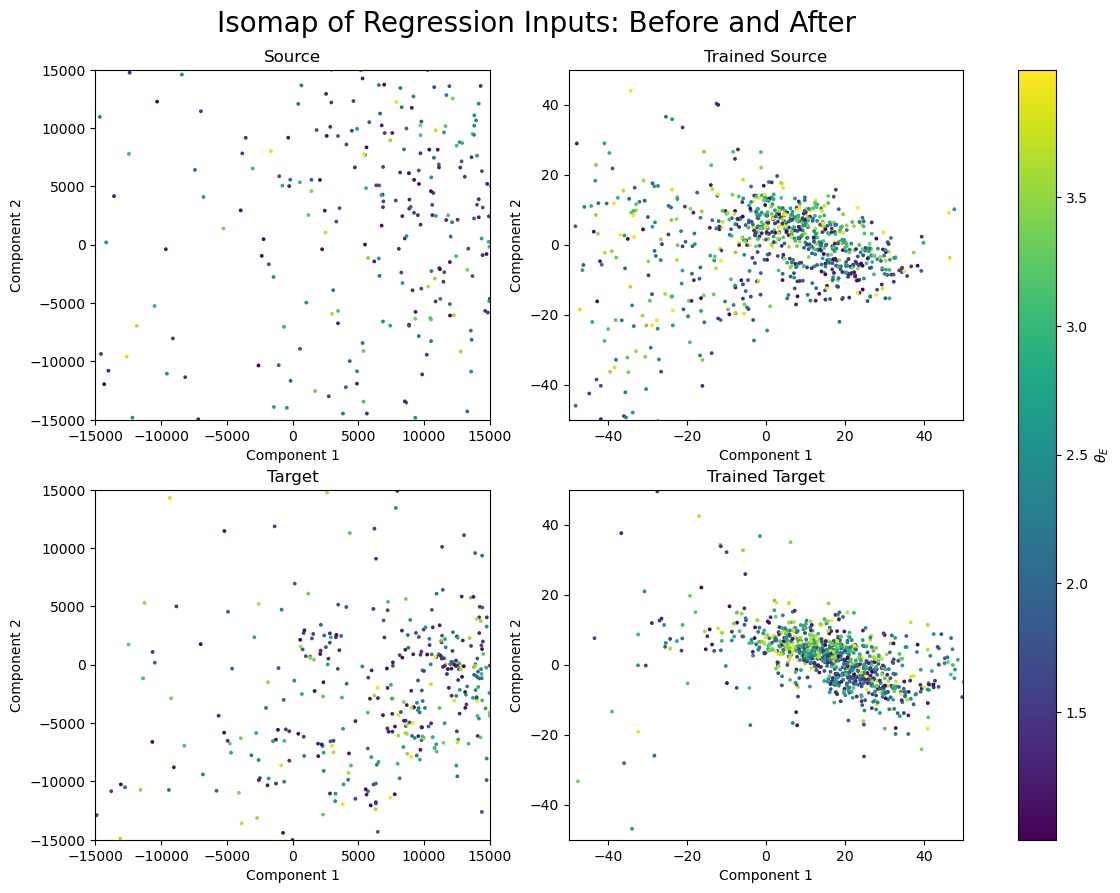


Epoch 0: 27.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2186
	Train Regression Loss: : 0.8927
	Train R2 Score: : -0.2599
 Validation Statistics:
	Val Source Regression Loss: : 0.3754
	Val Target Regression Loss: : 1.0289
	Val Source R2 Score: : 0.4748
	Val Target R2 Score: : -0.4257

Epoch 1: 27.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1965
	Train Regression Loss: : 0.3168
	Train R2 Score: : 0.5547
 Validation Statistics:
	Val Source Regression Loss: : 0.2602
	Val Target Regression Loss: : 0.6624
	Val Source R2 Score: : 0.6348
	Val Target R2 Score: : 0.0869

Epoch 2: 27.77s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1877
	Train Regression Loss: : 0.2308
	Train R2 Score: : 0.6752
 Validation Statistics:
	Val Source Regression Loss: : 0.2085
	Val Target Regression Loss: : 0.5247
	Val Source R2 Score: : 0.7069
	Val Target R2 Score: : 0.2802

Epoch 3: 27.02s
------------------------------

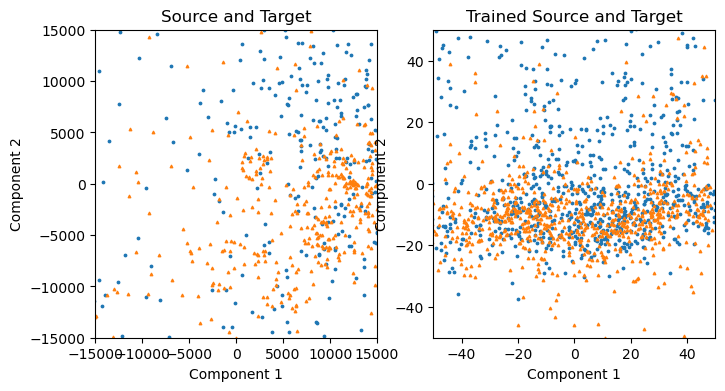

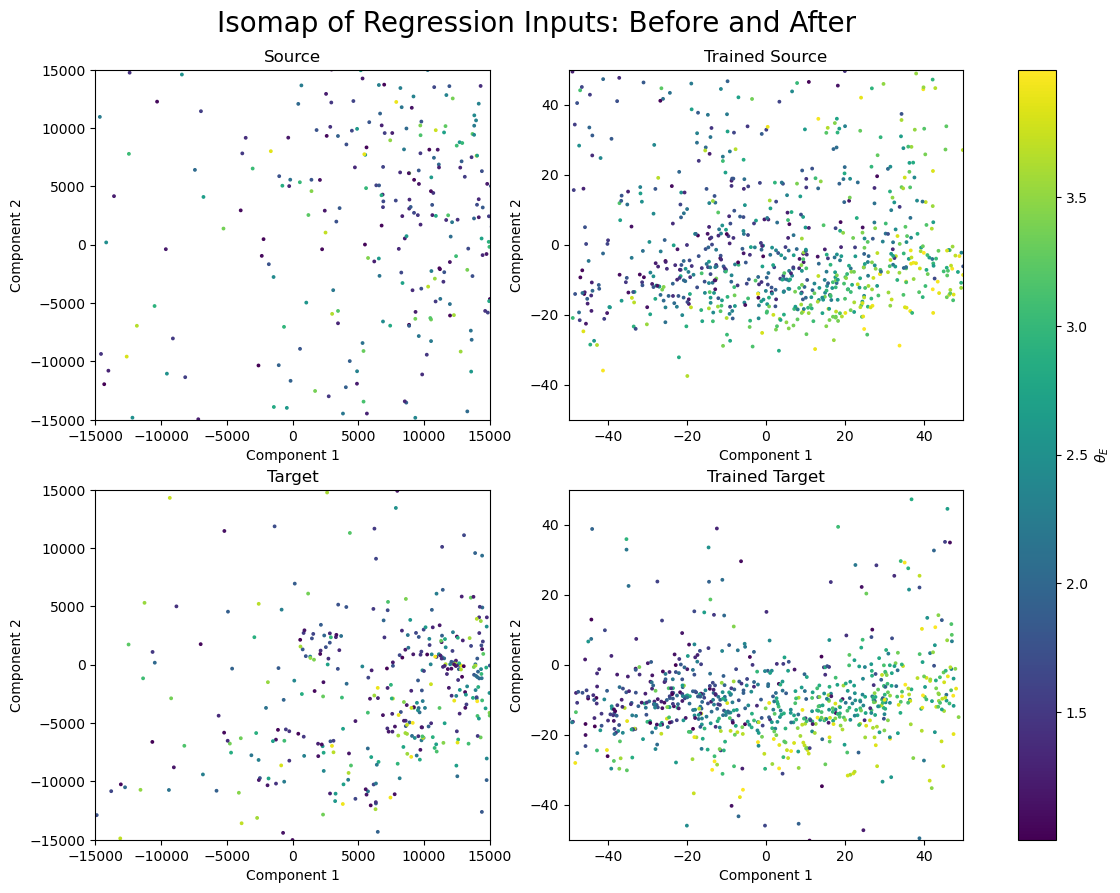

Saving Model... Done.

Epoch 5: 29.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1757
	Train Regression Loss: : 0.1373
	Train R2 Score: : 0.8060
 Validation Statistics:
	Val Source Regression Loss: : 0.1298
	Val Target Regression Loss: : 0.3662
	Val Source R2 Score: : 0.8174
	Val Target R2 Score: : 0.4932

Epoch 6: 30.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1755
	Train Regression Loss: : 0.1240
	Train R2 Score: : 0.8252
 Validation Statistics:
	Val Source Regression Loss: : 0.1212
	Val Target Regression Loss: : 0.3469
	Val Source R2 Score: : 0.8309
	Val Target R2 Score: : 0.5206

Epoch 7: 29.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1744
	Train Regression Loss: : 0.1136
	Train R2 Score: : 0.8396
 Validation Statistics:
	Val Source Regression Loss: : 0.1101
	Val Target Regression Loss: : 0.3188
	Val Source R2 Score: : 0.8461
	Val Target R2 Score: : 0.5548

Epoch 8: 32.64s
----------

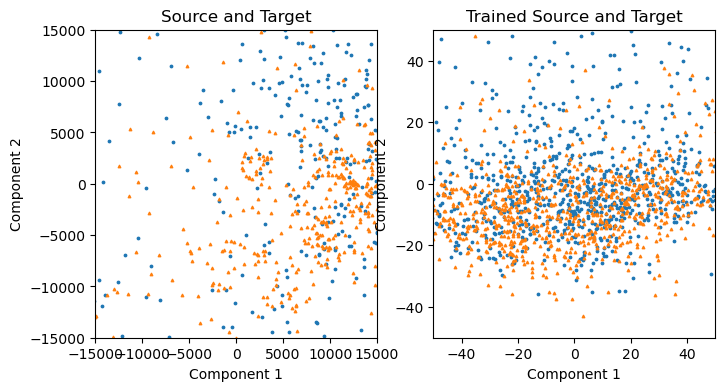

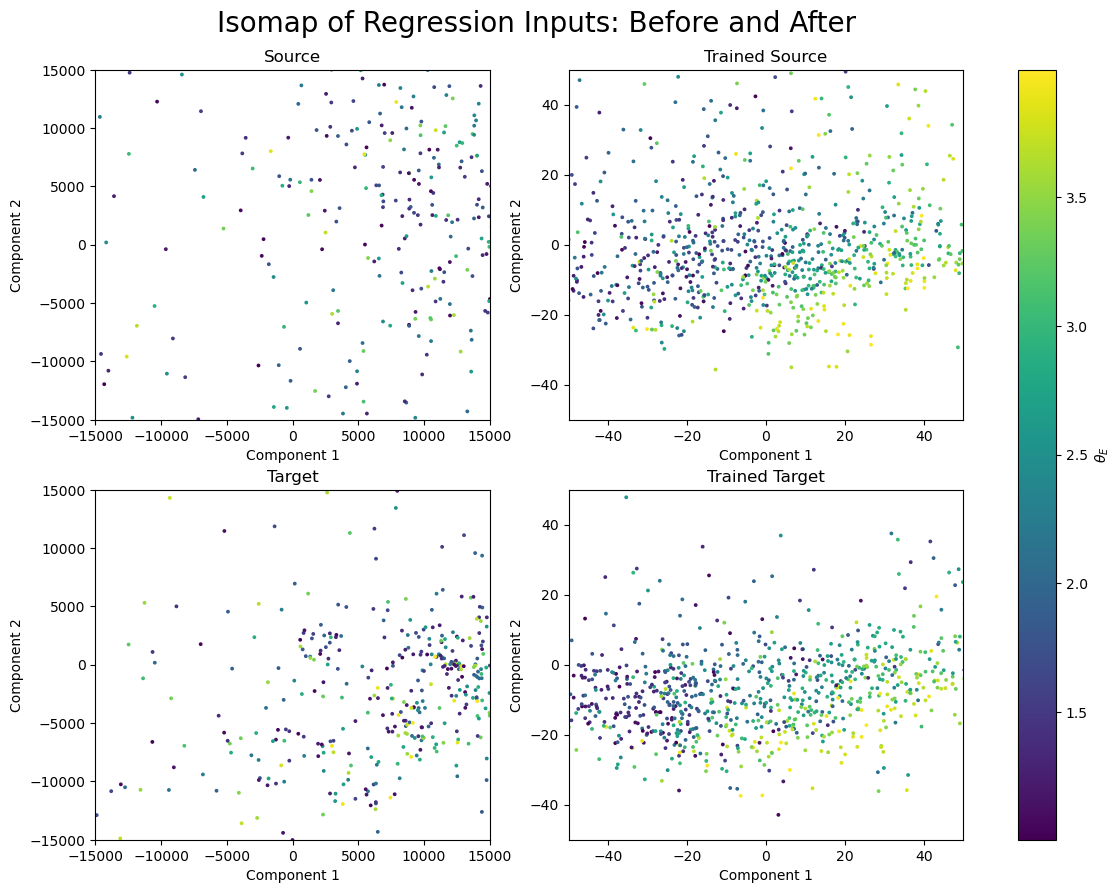

Saving Model... Done.

Epoch 10: 31.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1698
	Train Regression Loss: : 0.0948
	Train R2 Score: : 0.8664
 Validation Statistics:
	Val Source Regression Loss: : 0.0934
	Val Target Regression Loss: : 0.2936
	Val Source R2 Score: : 0.8691
	Val Target R2 Score: : 0.5914

Epoch 11: 28.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1684
	Train Regression Loss: : 0.0909
	Train R2 Score: : 0.8715
 Validation Statistics:
	Val Source Regression Loss: : 0.0898
	Val Target Regression Loss: : 0.2918
	Val Source R2 Score: : 0.8741
	Val Target R2 Score: : 0.5950

Epoch 12: 29.87s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1678
	Train Regression Loss: : 0.0878
	Train R2 Score: : 0.8760
 Validation Statistics:
	Val Source Regression Loss: : 0.0912
	Val Target Regression Loss: : 0.2917
	Val Source R2 Score: : 0.8721
	Val Target R2 Score: : 0.5929

Epoch 13: 28.25s
------

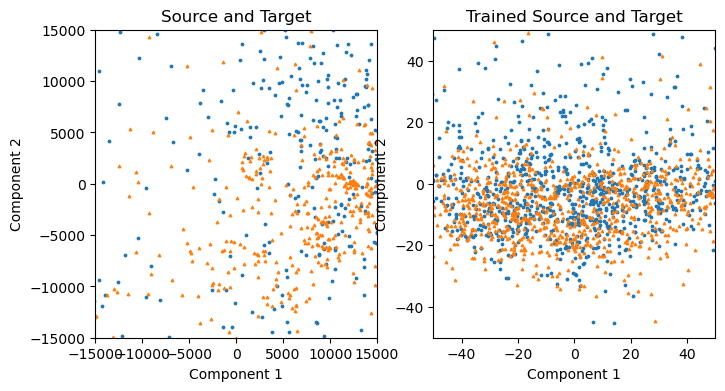

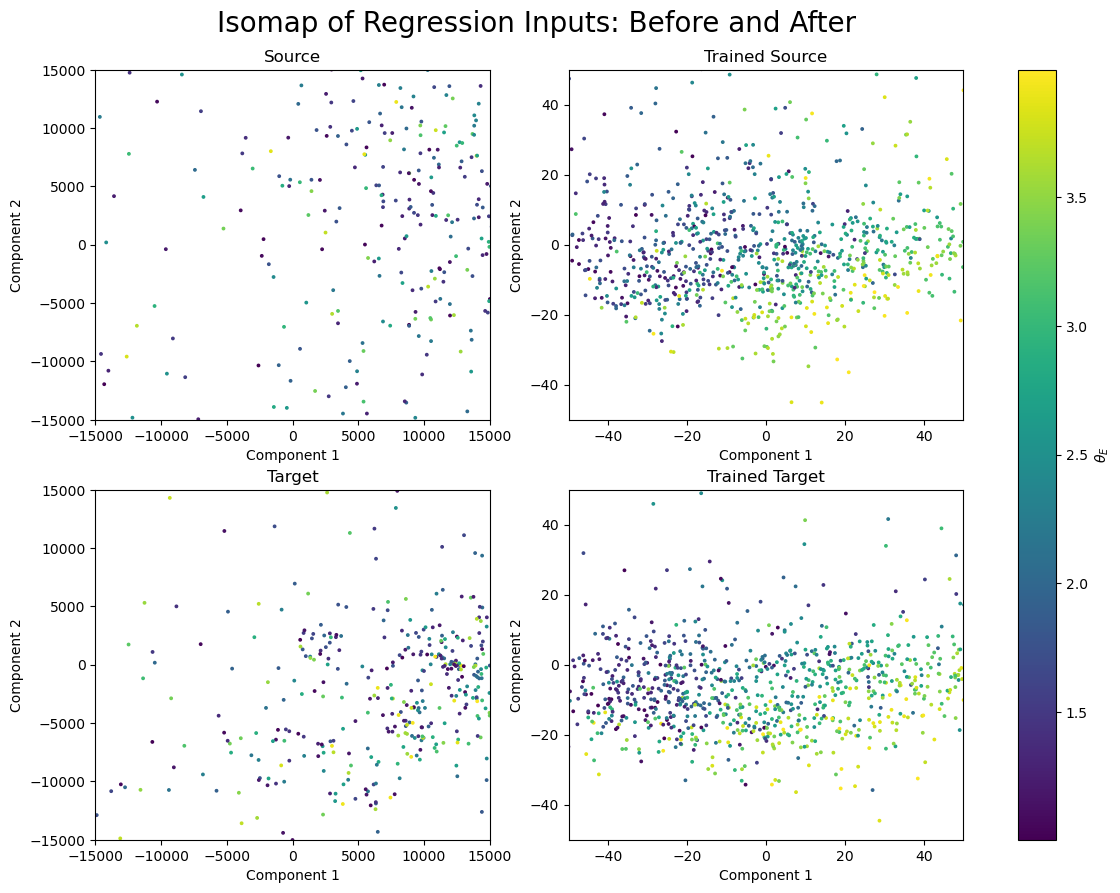

Saving Model... Done.

Epoch 15: 25.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1642
	Train Regression Loss: : 0.0797
	Train R2 Score: : 0.8874
 Validation Statistics:
	Val Source Regression Loss: : 0.0809
	Val Target Regression Loss: : 0.2808
	Val Source R2 Score: : 0.8862
	Val Target R2 Score: : 0.6109

Epoch 16: 25.43s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1639
	Train Regression Loss: : 0.0771
	Train R2 Score: : 0.8910
 Validation Statistics:
	Val Source Regression Loss: : 0.0796
	Val Target Regression Loss: : 0.2660
	Val Source R2 Score: : 0.8878
	Val Target R2 Score: : 0.6324

Epoch 17: 26.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1624
	Train Regression Loss: : 0.0751
	Train R2 Score: : 0.8941
 Validation Statistics:
	Val Source Regression Loss: : 0.0768
	Val Target Regression Loss: : 0.2680
	Val Source R2 Score: : 0.8920
	Val Target R2 Score: : 0.6280

Epoch 18: 29.30s
------

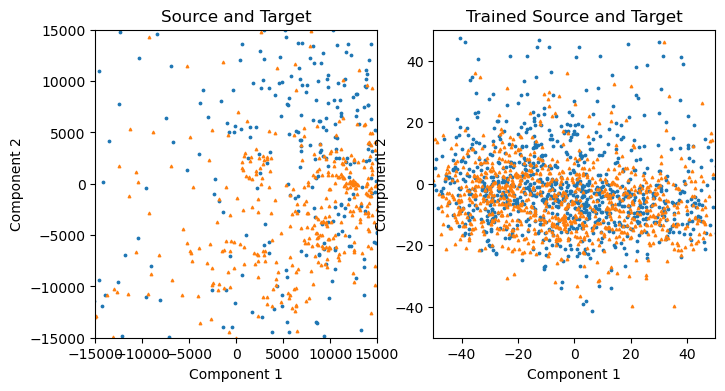

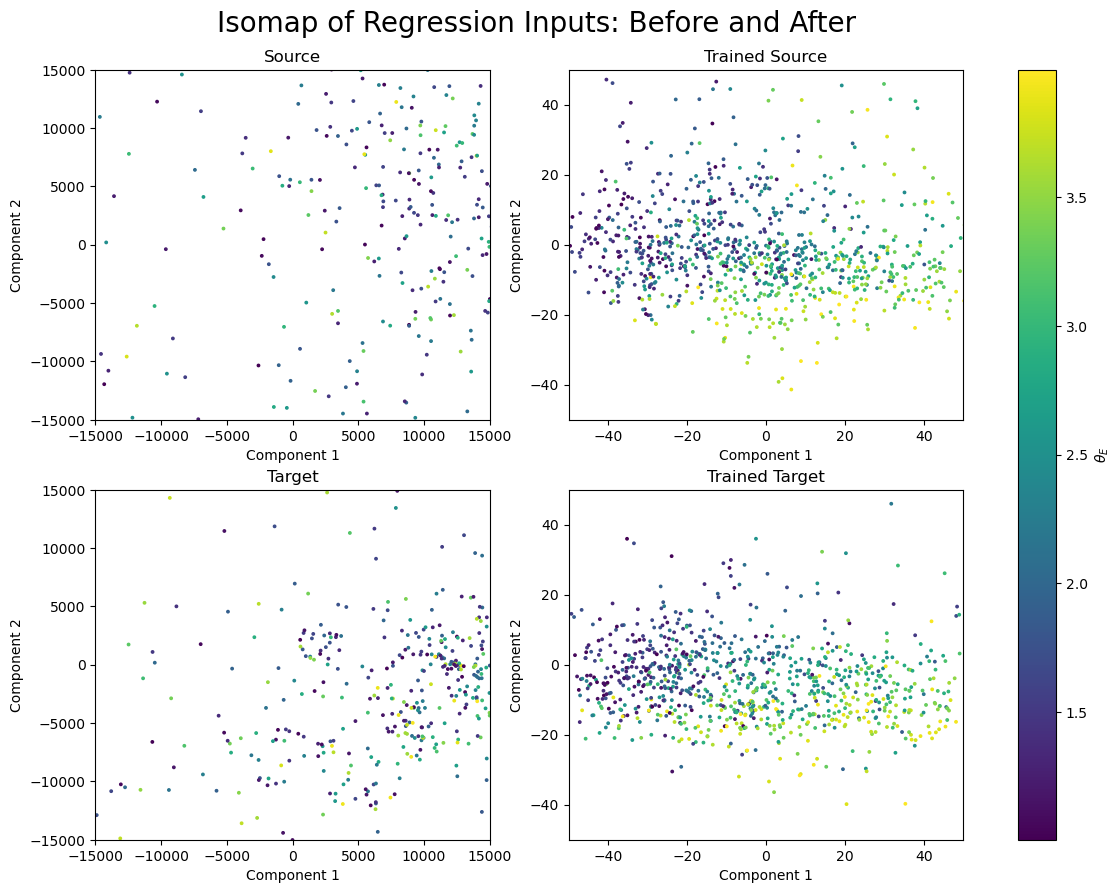

Saving Model... Done.

Epoch 20: 29.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1611
	Train Regression Loss: : 0.0703
	Train R2 Score: : 0.9006
 Validation Statistics:
	Val Source Regression Loss: : 0.0731
	Val Target Regression Loss: : 0.2564
	Val Source R2 Score: : 0.8970
	Val Target R2 Score: : 0.6485

Epoch 21: 25.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1599
	Train Regression Loss: : 0.0691
	Train R2 Score: : 0.9026
 Validation Statistics:
	Val Source Regression Loss: : 0.0699
	Val Target Regression Loss: : 0.2572
	Val Source R2 Score: : 0.9009
	Val Target R2 Score: : 0.6458

Epoch 22: 28.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1601
	Train Regression Loss: : 0.0678
	Train R2 Score: : 0.9045
 Validation Statistics:
	Val Source Regression Loss: : 0.0684
	Val Target Regression Loss: : 0.2564
	Val Source R2 Score: : 0.9040
	Val Target R2 Score: : 0.6483

Epoch 23: 26.00s
------

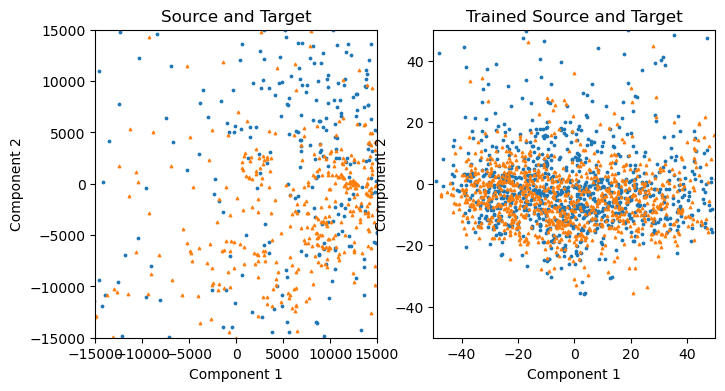

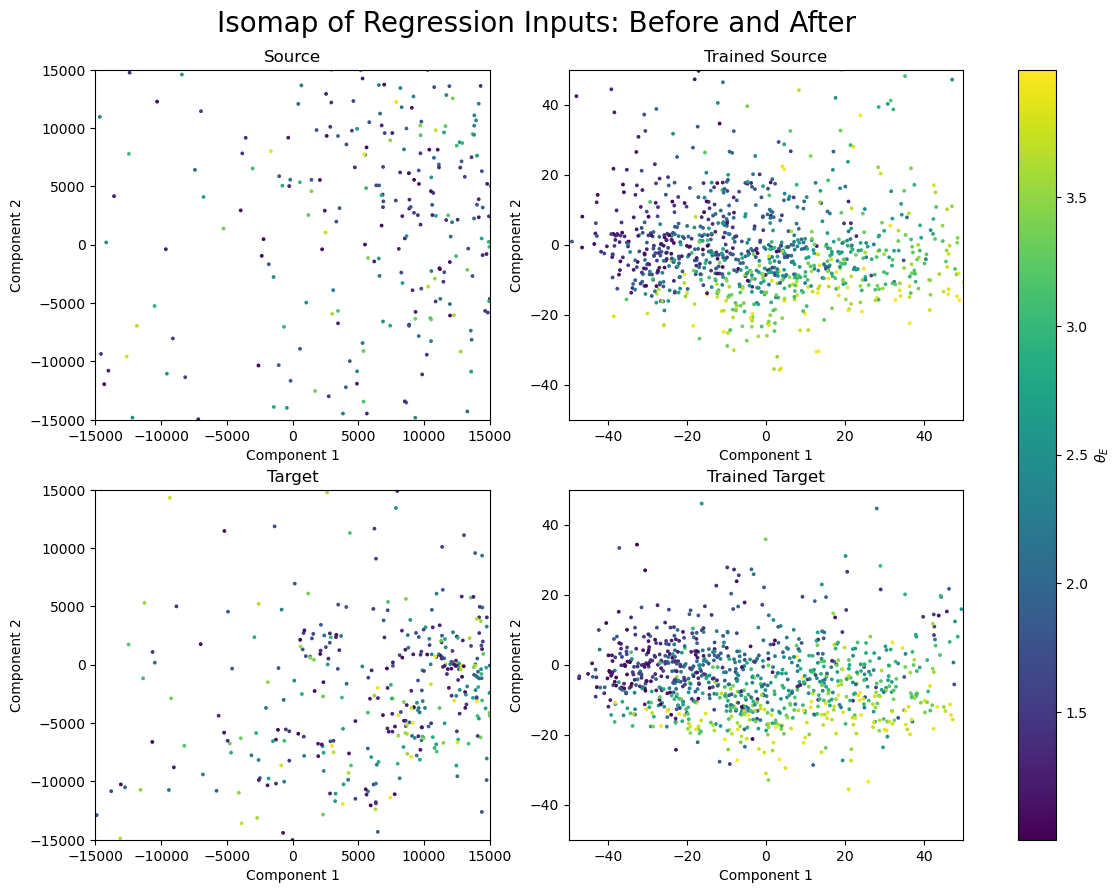

Saving Model... Done.

Epoch 25: 27.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1588
	Train Regression Loss: : 0.0648
	Train R2 Score: : 0.9083
 Validation Statistics:
	Val Source Regression Loss: : 0.0665
	Val Target Regression Loss: : 0.2469
	Val Source R2 Score: : 0.9066
	Val Target R2 Score: : 0.6560

Epoch 26: 29.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1585
	Train Regression Loss: : 0.0640
	Train R2 Score: : 0.9096
 Validation Statistics:
	Val Source Regression Loss: : 0.0654
	Val Target Regression Loss: : 0.2461
	Val Source R2 Score: : 0.9076
	Val Target R2 Score: : 0.6587

Epoch 27: 27.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1578
	Train Regression Loss: : 0.0625
	Train R2 Score: : 0.9116
 Validation Statistics:
	Val Source Regression Loss: : 0.0650
	Val Target Regression Loss: : 0.2417
	Val Source R2 Score: : 0.9069
	Val Target R2 Score: : 0.6647

Epoch 28: 27.75s
------

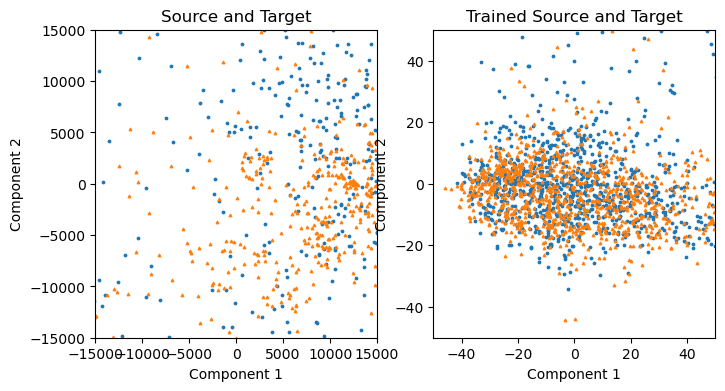

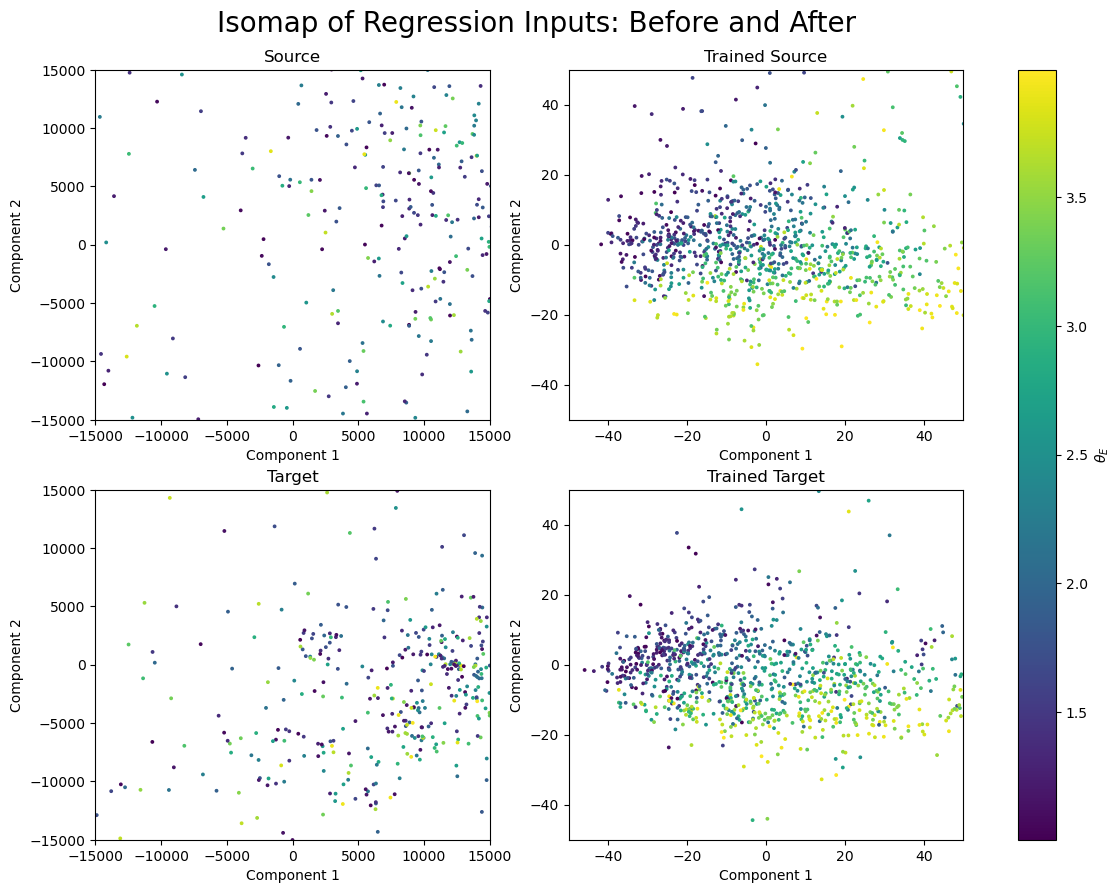

Saving Model... Done.

Epoch 30: 25.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1557
	Train Regression Loss: : 0.0606
	Train R2 Score: : 0.9146
 Validation Statistics:
	Val Source Regression Loss: : 0.0616
	Val Target Regression Loss: : 0.2378
	Val Source R2 Score: : 0.9141
	Val Target R2 Score: : 0.6686

Epoch 31: 27.05s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1566
	Train Regression Loss: : 0.0600
	Train R2 Score: : 0.9152
 Validation Statistics:
	Val Source Regression Loss: : 0.0626
	Val Target Regression Loss: : 0.2377
	Val Source R2 Score: : 0.9112
	Val Target R2 Score: : 0.6730

Epoch 32: 25.29s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1560
	Train Regression Loss: : 0.0594
	Train R2 Score: : 0.9157
 Validation Statistics:
	Val Source Regression Loss: : 0.0615
	Val Target Regression Loss: : 0.2333
	Val Source R2 Score: : 0.9128
	Val Target R2 Score: : 0.6777

Epoch 33: 26.36s
------

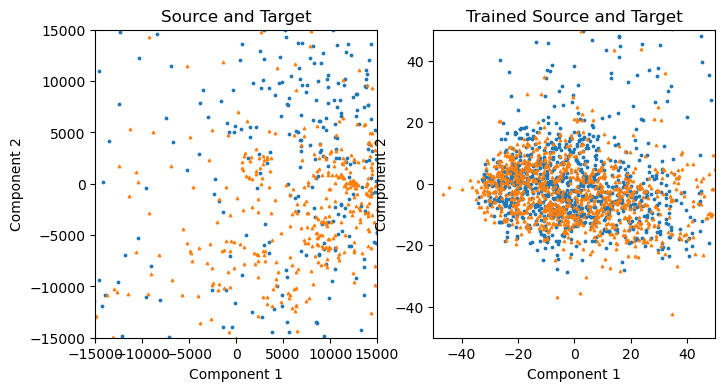

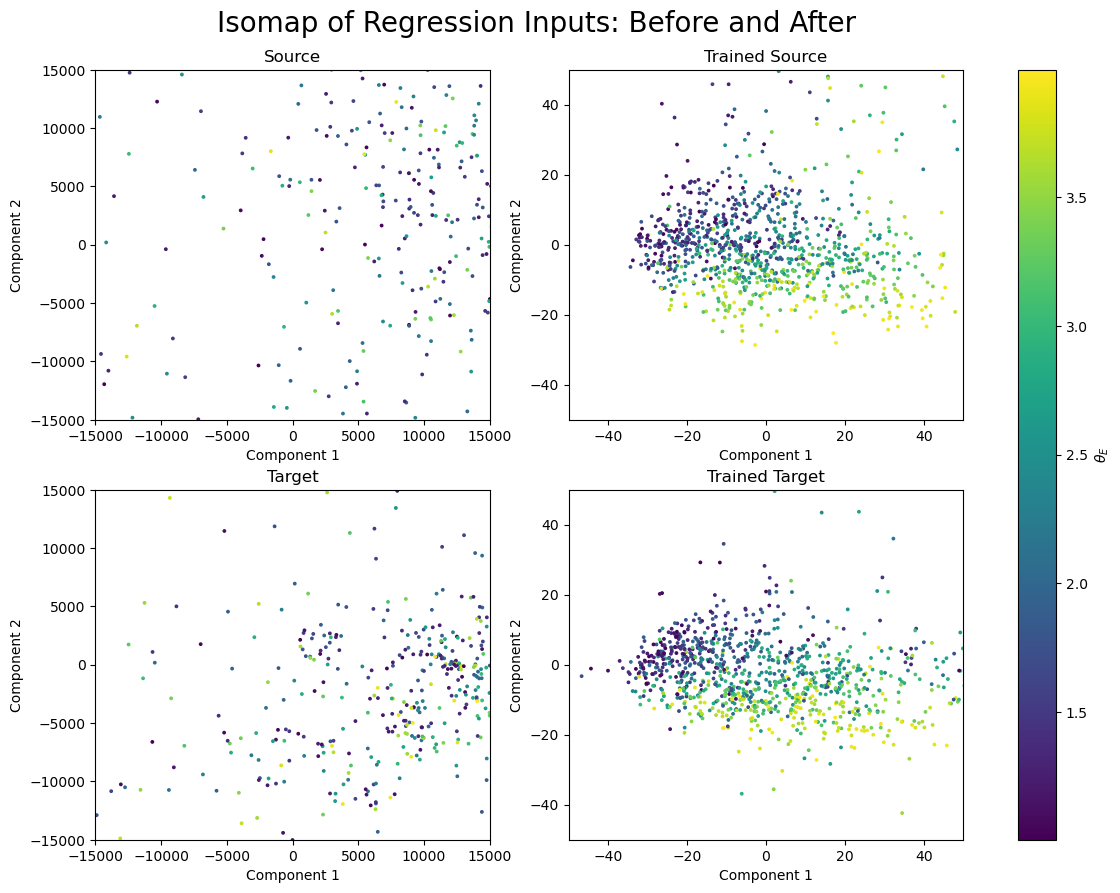

Saving Model... Done.

Epoch 35: 28.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1551
	Train Regression Loss: : 0.0581
	Train R2 Score: : 0.9178
 Validation Statistics:
	Val Source Regression Loss: : 0.0598
	Val Target Regression Loss: : 0.2284
	Val Source R2 Score: : 0.9165
	Val Target R2 Score: : 0.6830

Epoch 36: 31.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1554
	Train Regression Loss: : 0.0572
	Train R2 Score: : 0.9190
 Validation Statistics:
	Val Source Regression Loss: : 0.0574
	Val Target Regression Loss: : 0.2275
	Val Source R2 Score: : 0.9194
	Val Target R2 Score: : 0.6850

Epoch 37: 33.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1568
	Train Regression Loss: : 0.0564
	Train R2 Score: : 0.9204
 Validation Statistics:
	Val Source Regression Loss: : 0.0568
	Val Target Regression Loss: : 0.2286
	Val Source R2 Score: : 0.9197
	Val Target R2 Score: : 0.6874

Epoch 38: 30.88s
------

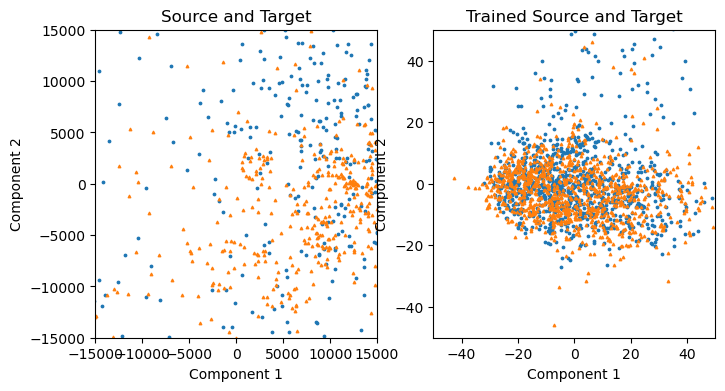

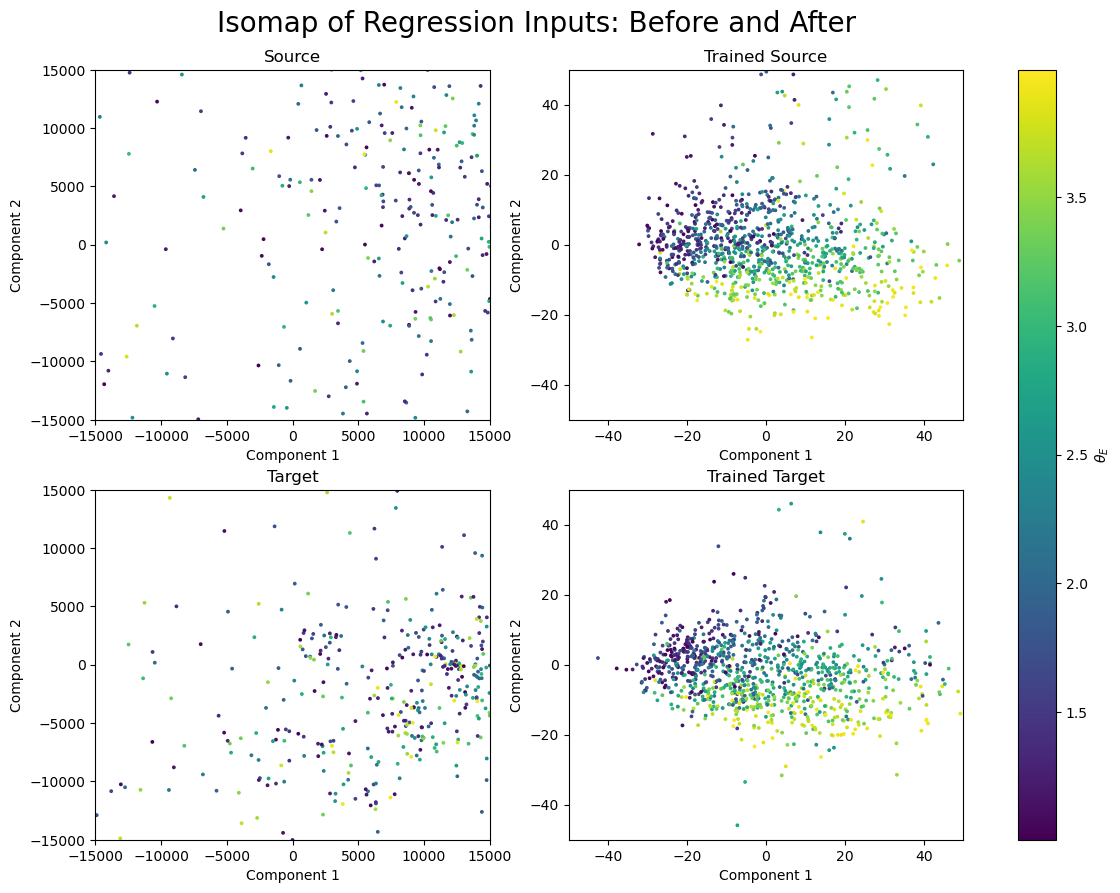


Epoch 40: 31.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1557
	Train Regression Loss: : 0.0554
	Train R2 Score: : 0.9217
 Validation Statistics:
	Val Source Regression Loss: : 0.0565
	Val Target Regression Loss: : 0.2274
	Val Source R2 Score: : 0.9207
	Val Target R2 Score: : 0.6851

Epoch 41: 30.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1564
	Train Regression Loss: : 0.0552
	Train R2 Score: : 0.9218
 Validation Statistics:
	Val Source Regression Loss: : 0.0555
	Val Target Regression Loss: : 0.2248
	Val Source R2 Score: : 0.9216
	Val Target R2 Score: : 0.6878

Epoch 42: 31.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1557
	Train Regression Loss: : 0.0549
	Train R2 Score: : 0.9225
 Validation Statistics:
	Val Source Regression Loss: : 0.0557
	Val Target Regression Loss: : 0.2268
	Val Source R2 Score: : 0.9220
	Val Target R2 Score: : 0.6870

Epoch 43: 31.82s
----------------------------

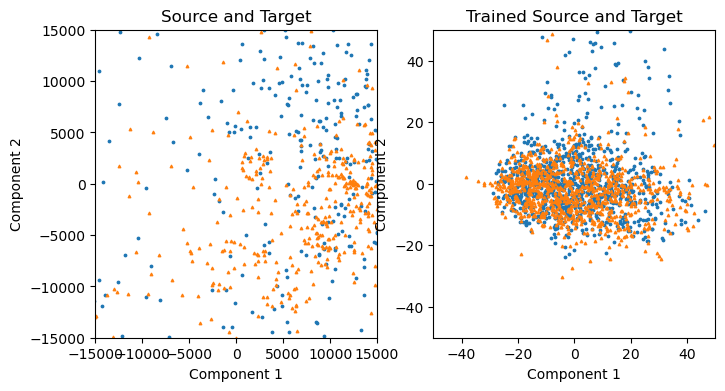

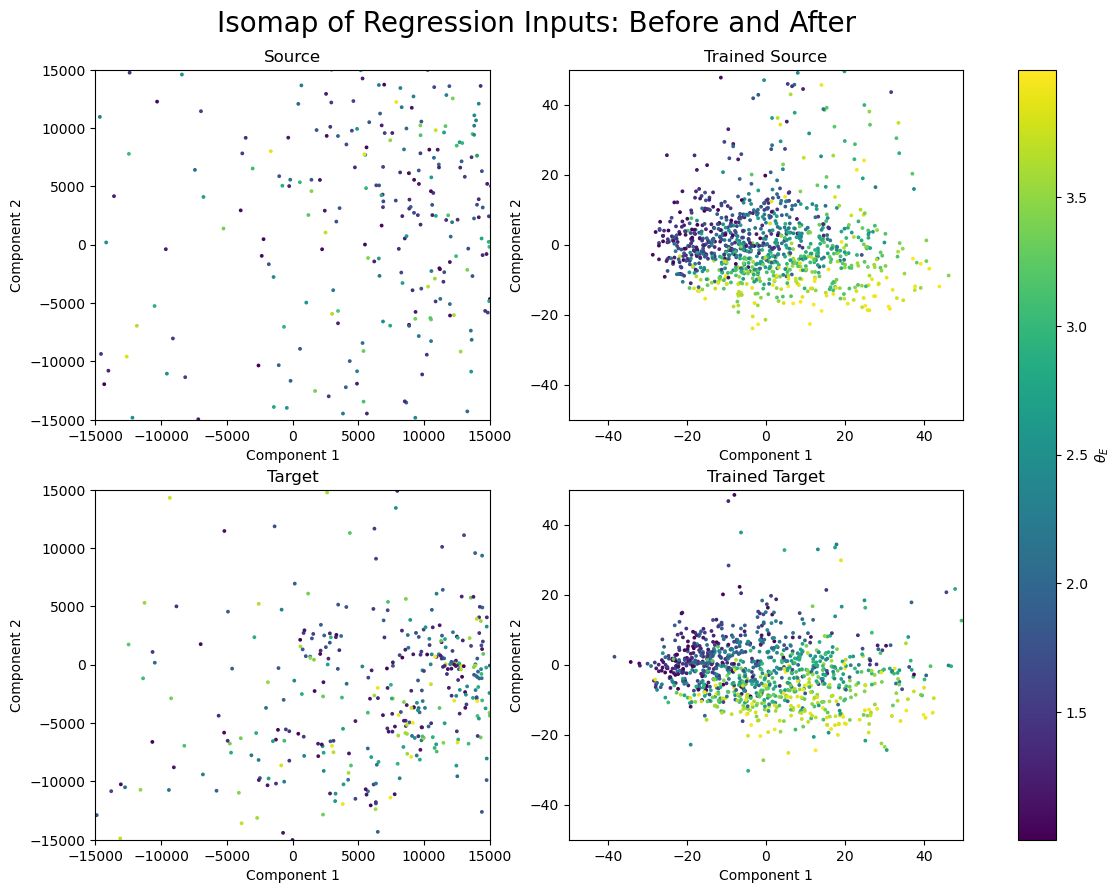

Saving Model... Done.

Epoch 45: 29.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1579
	Train Regression Loss: : 0.0541
	Train R2 Score: : 0.9238
 Validation Statistics:
	Val Source Regression Loss: : 0.0568
	Val Target Regression Loss: : 0.2192
	Val Source R2 Score: : 0.9199
	Val Target R2 Score: : 0.6945

Epoch 46: 31.62s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1580
	Train Regression Loss: : 0.0540
	Train R2 Score: : 0.9237
 Validation Statistics:
	Val Source Regression Loss: : 0.0543
	Val Target Regression Loss: : 0.2194
	Val Source R2 Score: : 0.9231
	Val Target R2 Score: : 0.6982

Epoch 47: 31.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1576
	Train Regression Loss: : 0.0537
	Train R2 Score: : 0.9238
 Validation Statistics:
	Val Source Regression Loss: : 0.0556
	Val Target Regression Loss: : 0.2249
	Val Source R2 Score: : 0.9215
	Val Target R2 Score: : 0.6908

Epoch 48: 30.77s
------

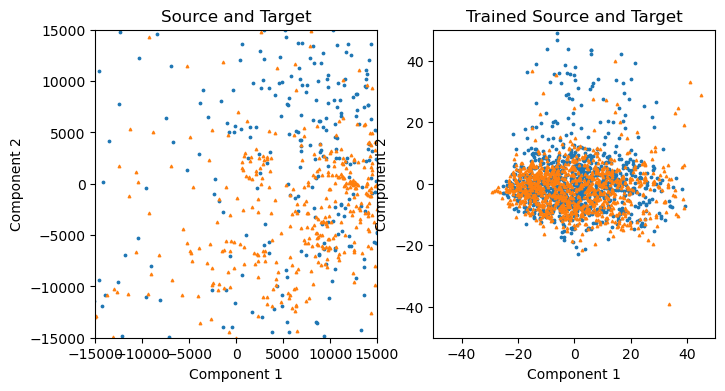

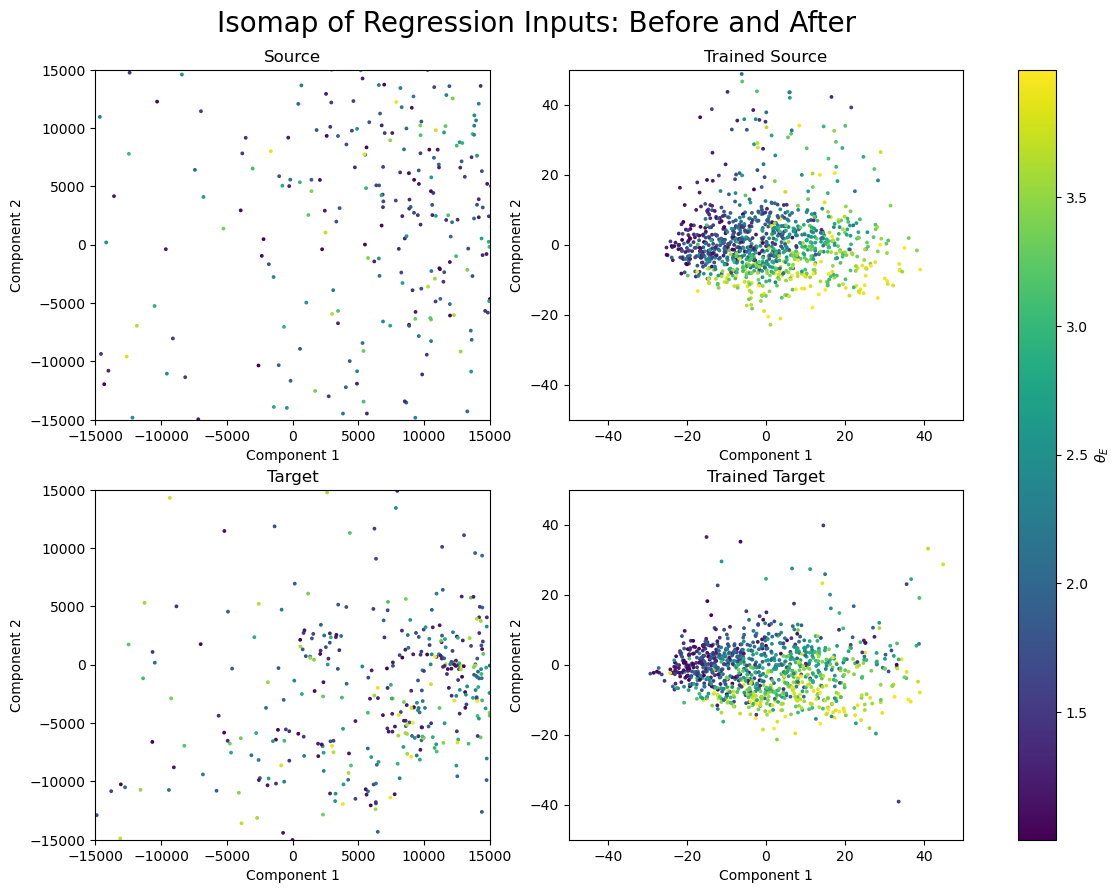

Saving Model... Done.

Epoch 50: 29.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1584
	Train Regression Loss: : 0.0531
	Train R2 Score: : 0.9251
 Validation Statistics:
	Val Source Regression Loss: : 0.0540
	Val Target Regression Loss: : 0.2158
	Val Source R2 Score: : 0.9237
	Val Target R2 Score: : 0.7025

Epoch 51: 29.69s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1591
	Train Regression Loss: : 0.0531
	Train R2 Score: : 0.9249
 Validation Statistics:
	Val Source Regression Loss: : 0.0544
	Val Target Regression Loss: : 0.2089
	Val Source R2 Score: : 0.9237
	Val Target R2 Score: : 0.7108

Epoch 52: 28.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1590
	Train Regression Loss: : 0.0535
	Train R2 Score: : 0.9245
 Validation Statistics:
	Val Source Regression Loss: : 0.0541
	Val Target Regression Loss: : 0.2149
	Val Source R2 Score: : 0.9240
	Val Target R2 Score: : 0.7041

Epoch 53: 28.79s
------

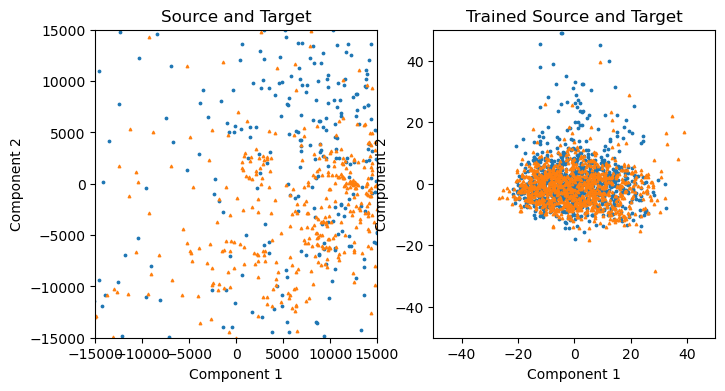

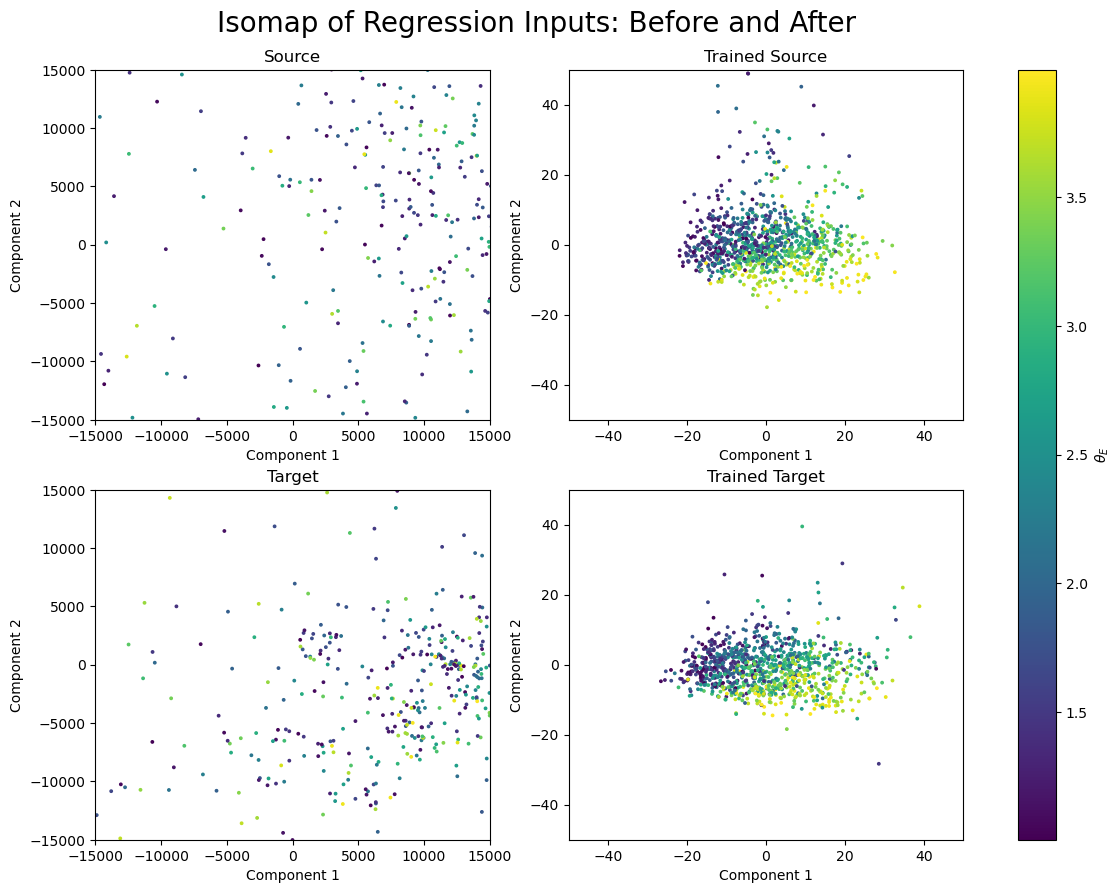

Saving Model... Done.

Epoch 55: 29.81s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1618
	Train Regression Loss: : 0.0534
	Train R2 Score: : 0.9243
 Validation Statistics:
	Val Source Regression Loss: : 0.0545
	Val Target Regression Loss: : 0.2079
	Val Source R2 Score: : 0.9241
	Val Target R2 Score: : 0.7135

Epoch 56: 28.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1624
	Train Regression Loss: : 0.0533
	Train R2 Score: : 0.9245
 Validation Statistics:
	Val Source Regression Loss: : 0.0542
	Val Target Regression Loss: : 0.2085
	Val Source R2 Score: : 0.9243
	Val Target R2 Score: : 0.7107

Epoch 57: 30.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1627
	Train Regression Loss: : 0.0538
	Train R2 Score: : 0.9242
 Validation Statistics:
	Val Source Regression Loss: : 0.0557
	Val Target Regression Loss: : 0.2073
	Val Source R2 Score: : 0.9214
	Val Target R2 Score: : 0.7109

Epoch 58: 29.55s
------

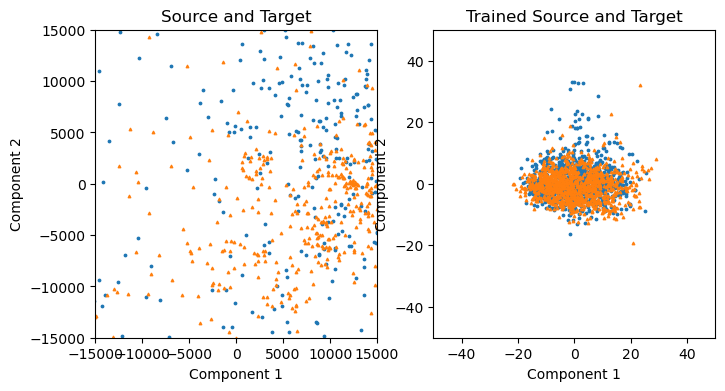

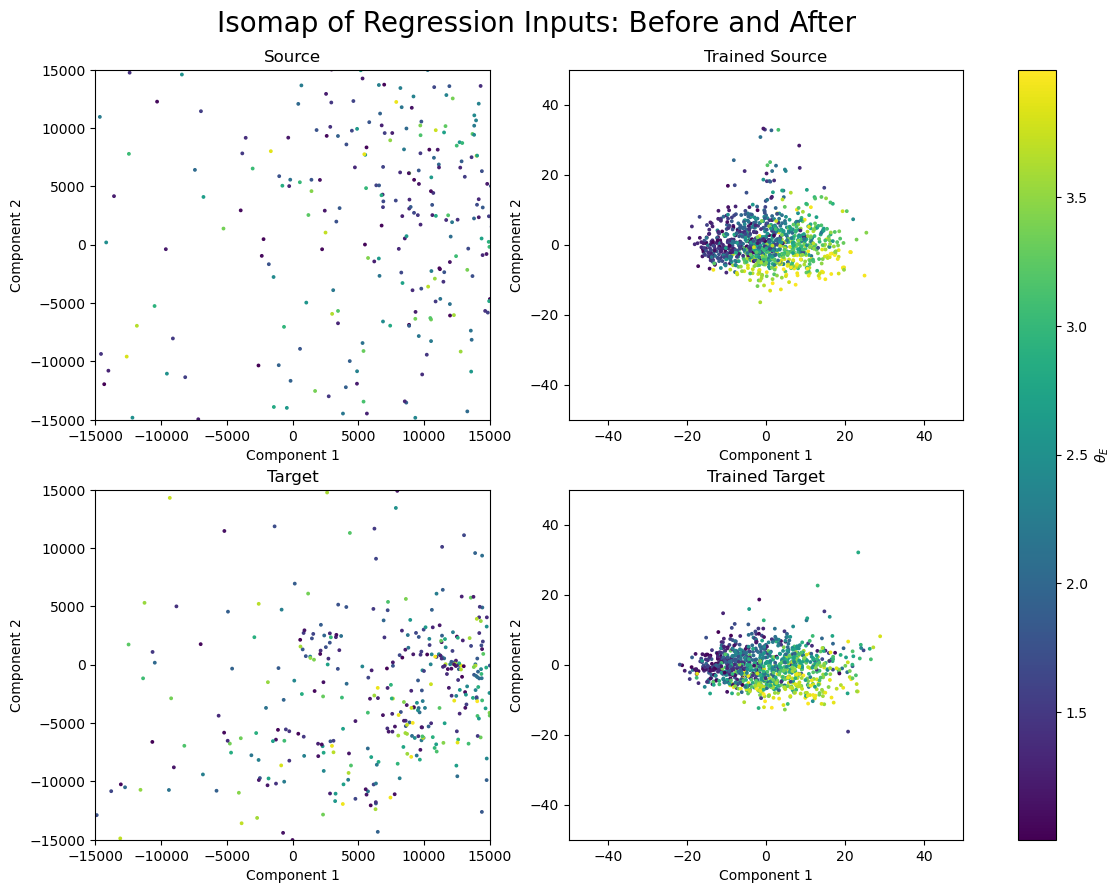

Saving Model... Done.

Epoch 60: 32.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1647
	Train Regression Loss: : 0.0547
	Train R2 Score: : 0.9225
 Validation Statistics:
	Val Source Regression Loss: : 0.0551
	Val Target Regression Loss: : 0.2061
	Val Source R2 Score: : 0.9224
	Val Target R2 Score: : 0.7172

Epoch 61: 33.80s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1653
	Train Regression Loss: : 0.0554
	Train R2 Score: : 0.9215
 Validation Statistics:
	Val Source Regression Loss: : 0.0574
	Val Target Regression Loss: : 0.2051
	Val Source R2 Score: : 0.9193
	Val Target R2 Score: : 0.7172

Epoch 62: 31.96s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1656
	Train Regression Loss: : 0.0561
	Train R2 Score: : 0.9206
 Validation Statistics:
	Val Source Regression Loss: : 0.0570
	Val Target Regression Loss: : 0.2010
	Val Source R2 Score: : 0.9201
	Val Target R2 Score: : 0.7229

Epoch 63: 28.90s
------

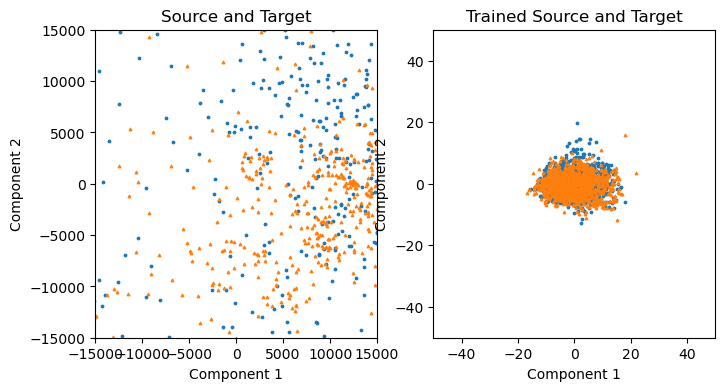

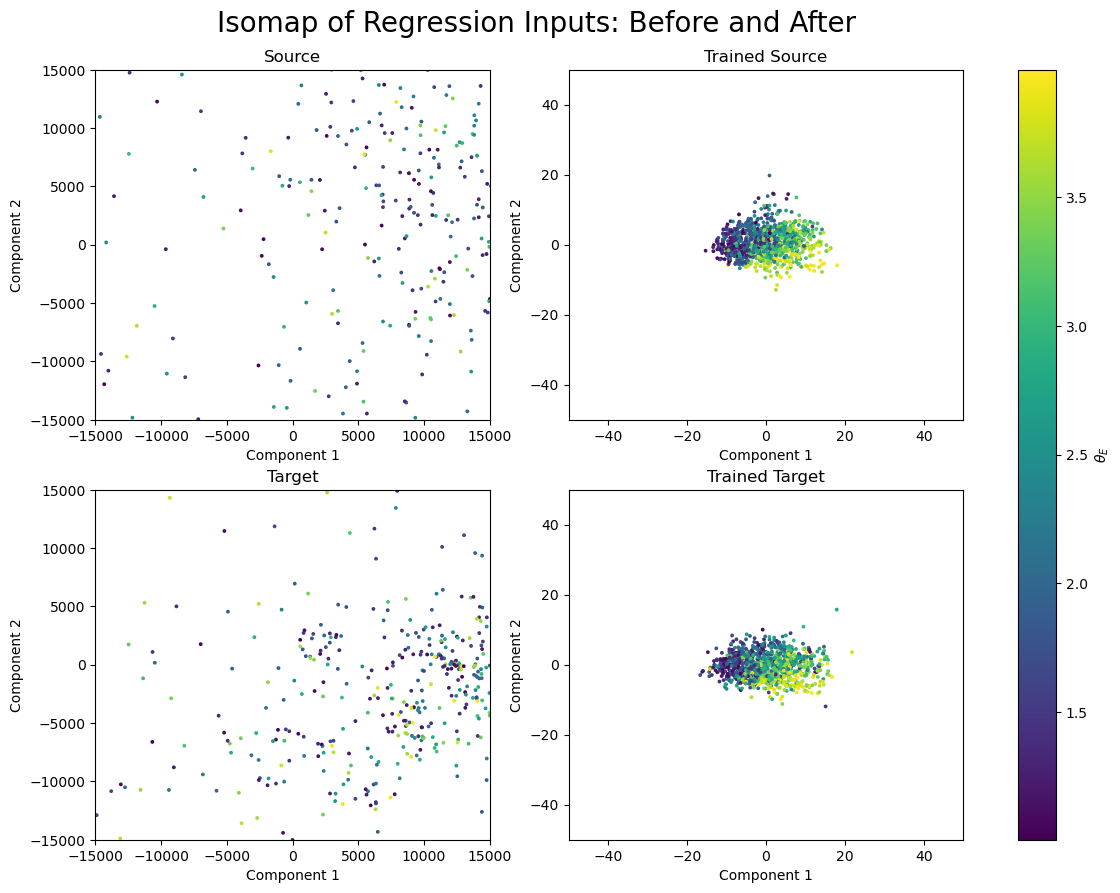

Saving Model... Done.

Epoch 65: 31.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1691
	Train Regression Loss: : 0.0593
	Train R2 Score: : 0.9160
 Validation Statistics:
	Val Source Regression Loss: : 0.0613
	Val Target Regression Loss: : 0.1996
	Val Source R2 Score: : 0.9141
	Val Target R2 Score: : 0.7227

Epoch 66: 26.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1704
	Train Regression Loss: : 0.0609
	Train R2 Score: : 0.9141
 Validation Statistics:
	Val Source Regression Loss: : 0.0644
	Val Target Regression Loss: : 0.2033
	Val Source R2 Score: : 0.9097
	Val Target R2 Score: : 0.7160

Epoch 67: 27.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1708
	Train Regression Loss: : 0.0628
	Train R2 Score: : 0.9111
 Validation Statistics:
	Val Source Regression Loss: : 0.0638
	Val Target Regression Loss: : 0.1970
	Val Source R2 Score: : 0.9112
	Val Target R2 Score: : 0.7283

Epoch 68: 26.51s
------

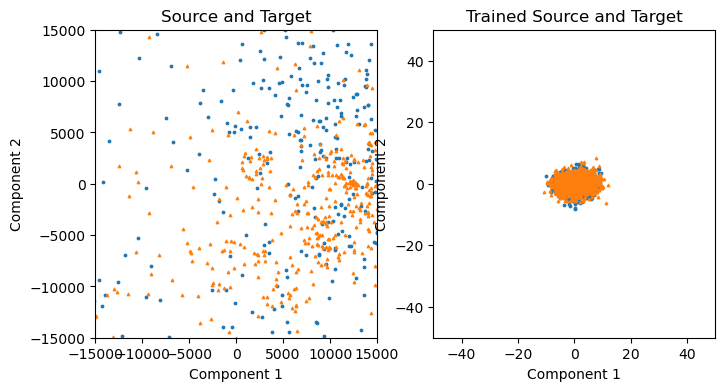

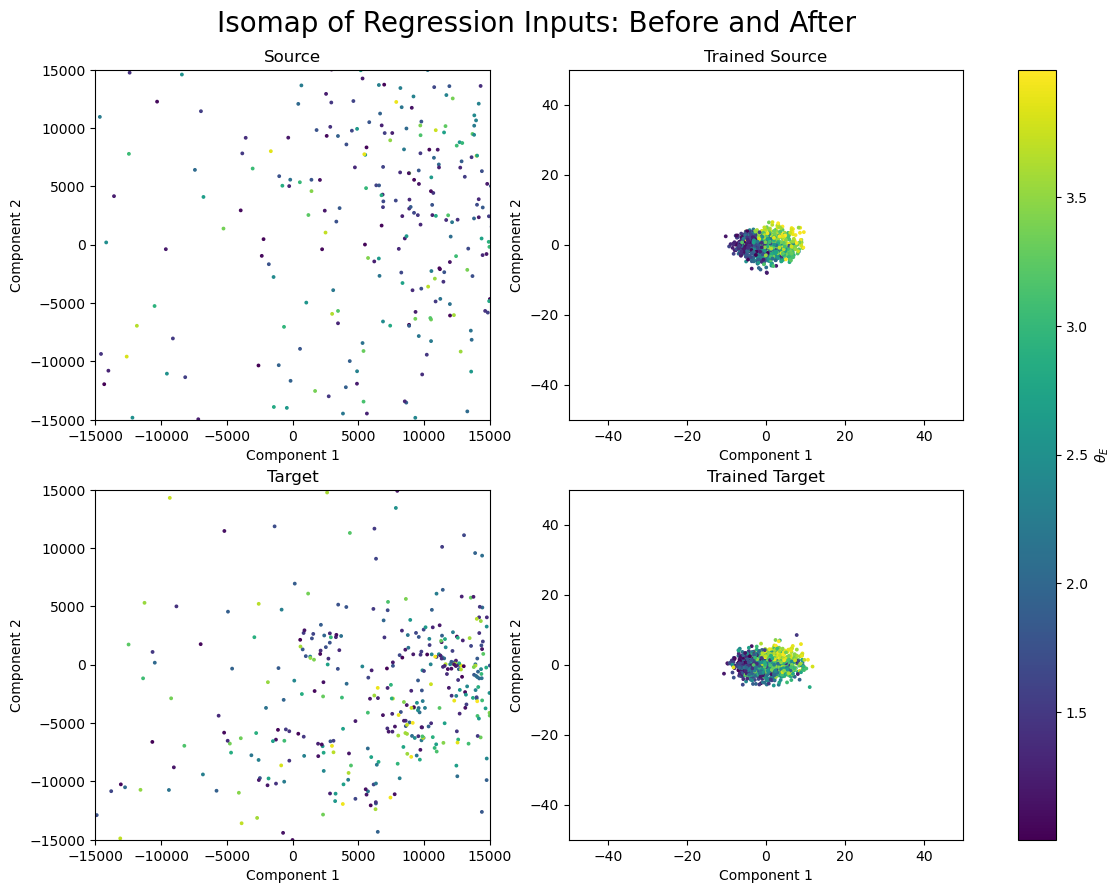


Epoch 70: 26.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1765
	Train Regression Loss: : 0.0713
	Train R2 Score: : 0.8990
 Validation Statistics:
	Val Source Regression Loss: : 0.0755
	Val Target Regression Loss: : 0.2010
	Val Source R2 Score: : 0.8945
	Val Target R2 Score: : 0.7204

Epoch 71: 26.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1783
	Train Regression Loss: : 0.0758
	Train R2 Score: : 0.8933
 Validation Statistics:
	Val Source Regression Loss: : 0.0792
	Val Target Regression Loss: : 0.2063
	Val Source R2 Score: : 0.8879
	Val Target R2 Score: : 0.7144

Epoch 72: 27.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1805
	Train Regression Loss: : 0.0812
	Train R2 Score: : 0.8850
 Validation Statistics:
	Val Source Regression Loss: : 0.0846
	Val Target Regression Loss: : 0.2067
	Val Source R2 Score: : 0.8807
	Val Target R2 Score: : 0.7161

Epoch 73: 26.80s
----------------------------

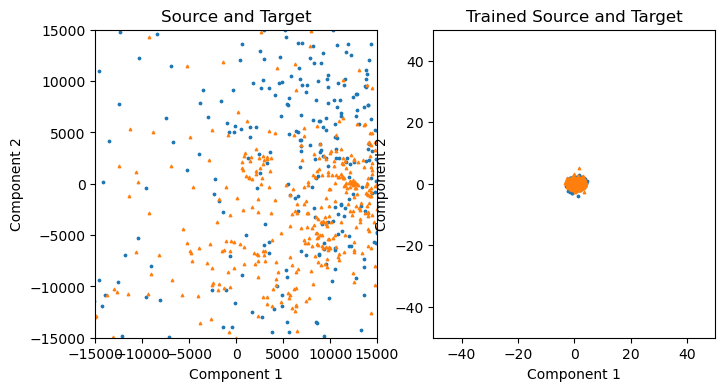

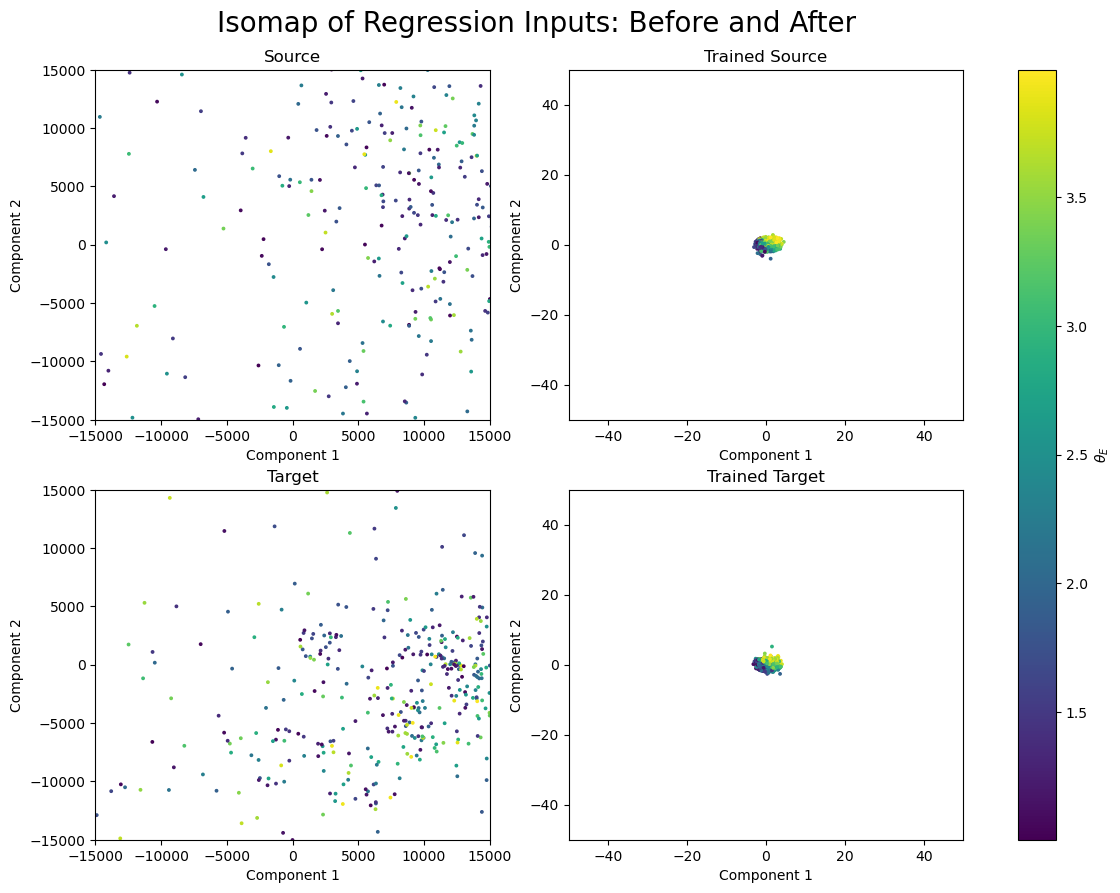


Epoch 75: 28.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1857
	Train Regression Loss: : 0.1011
	Train R2 Score: : 0.8573
 Validation Statistics:
	Val Source Regression Loss: : 0.1080
	Val Target Regression Loss: : 0.2188
	Val Source R2 Score: : 0.8483
	Val Target R2 Score: : 0.6995

Epoch 76: 27.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1853
	Train Regression Loss: : 0.1076
	Train R2 Score: : 0.8488
 Validation Statistics:
	Val Source Regression Loss: : 0.1145
	Val Target Regression Loss: : 0.2252
	Val Source R2 Score: : 0.8409
	Val Target R2 Score: : 0.6903

Epoch 77: 28.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1862
	Train Regression Loss: : 0.1165
	Train R2 Score: : 0.8358
 Validation Statistics:
	Val Source Regression Loss: : 0.1216
	Val Target Regression Loss: : 0.2261
	Val Source R2 Score: : 0.8315
	Val Target R2 Score: : 0.6901

Epoch 78: 27.63s
----------------------------

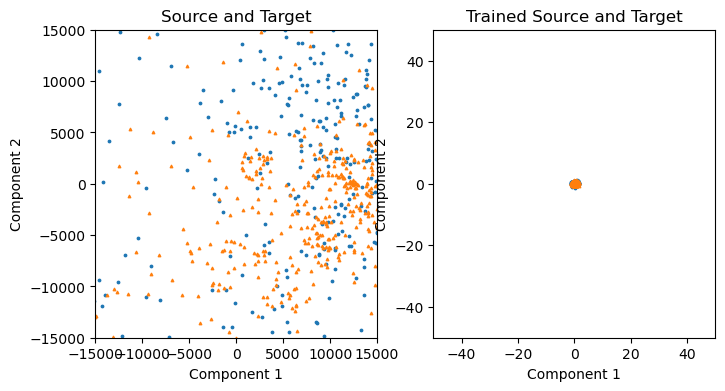

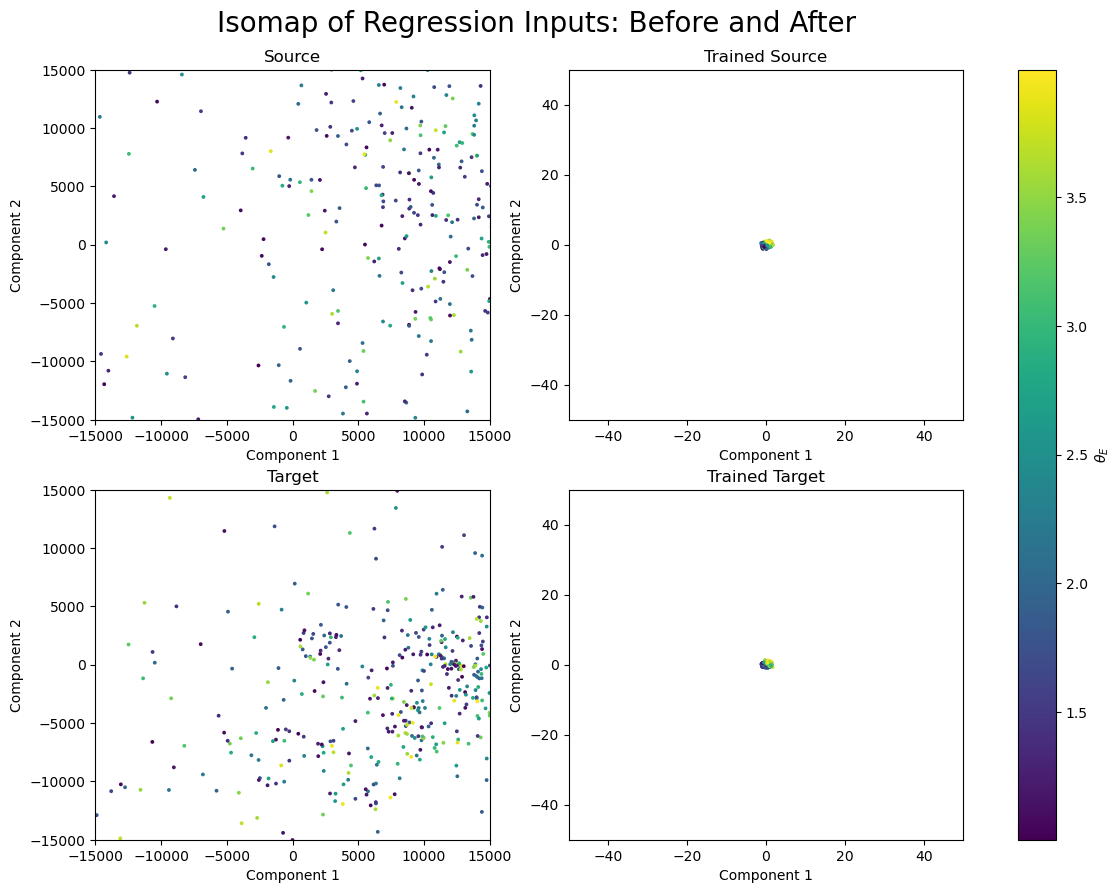


Epoch 80: 22.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1864
	Train Regression Loss: : 0.1390
	Train R2 Score: : 0.8045
 Validation Statistics:
	Val Source Regression Loss: : 0.1447
	Val Target Regression Loss: : 0.2478
	Val Source R2 Score: : 0.7992
	Val Target R2 Score: : 0.6568

Epoch 81: 23.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1865
	Train Regression Loss: : 0.1452
	Train R2 Score: : 0.7961
 Validation Statistics:
	Val Source Regression Loss: : 0.1510
	Val Target Regression Loss: : 0.2543
	Val Source R2 Score: : 0.7883
	Val Target R2 Score: : 0.6516

Epoch 82: 26.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1862
	Train Regression Loss: : 0.1522
	Train R2 Score: : 0.7864
 Validation Statistics:
	Val Source Regression Loss: : 0.1585
	Val Target Regression Loss: : 0.2634
	Val Source R2 Score: : 0.7783
	Val Target R2 Score: : 0.6357

Epoch 83: 27.85s
----------------------------

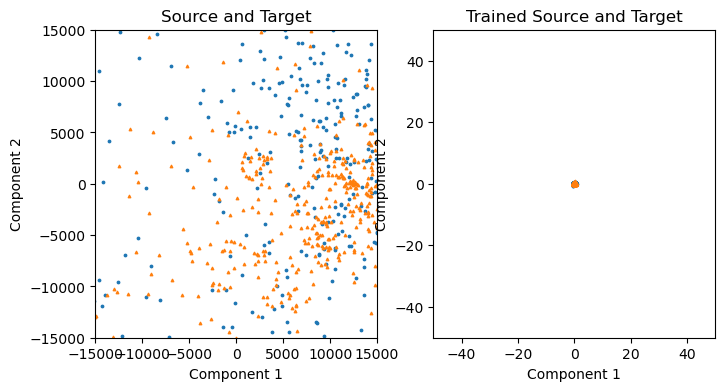

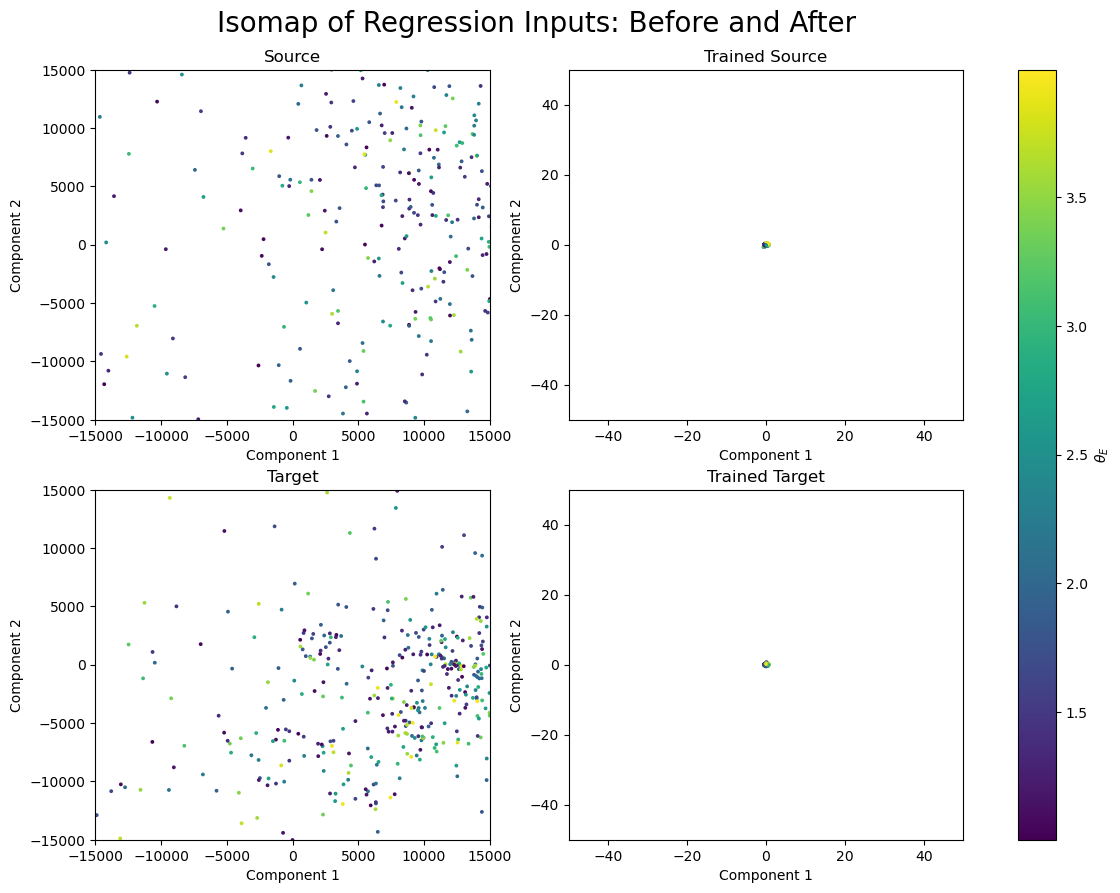


Epoch 85: 29.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1864
	Train Regression Loss: : 0.1715
	Train R2 Score: : 0.7593
 Validation Statistics:
	Val Source Regression Loss: : 0.1769
	Val Target Regression Loss: : 0.2797
	Val Source R2 Score: : 0.7549
	Val Target R2 Score: : 0.6149

Epoch 86: 27.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1870
	Train Regression Loss: : 0.1763
	Train R2 Score: : 0.7525
 Validation Statistics:
	Val Source Regression Loss: : 0.1823
	Val Target Regression Loss: : 0.2883
	Val Source R2 Score: : 0.7444
	Val Target R2 Score: : 0.6042

Epoch 87: 28.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1866
	Train Regression Loss: : 0.1824
	Train R2 Score: : 0.7440
 Validation Statistics:
	Val Source Regression Loss: : 0.1885
	Val Target Regression Loss: : 0.2913
	Val Source R2 Score: : 0.7364
	Val Target R2 Score: : 0.5981


KeyboardInterrupt: 

In [7]:
print("Beginning Training...")
mod_name = "models/mb_lenscolor_jul25_1740"
# Train
best_target_R2 = -1.0
for i in range(stats['epoch_no'], stats['epoch_no'] + epochs):
        if (i % 5 == 0):
            print("Generating Isomap...")
            source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 15000, 50, save = True)
            if (len(stats['val_target_r2_score']) > 0) and (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                state = {
                        'epoch': stats['epoch_no'],
                        'state_dict': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        }
                torch.save(state, mod_name)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
            
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i, 2.5, 1.8)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])
        stats['epoch_no'] += 1

        
        print_epoch_scores(stats, i, time.time() - start_time)

In [8]:
# state = {
#     'epoch': stats['epoch_no'],
#     'state_dict': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
# }

# torch.save(state, mod_name)
json.dump(stats, open(mod_name+'.json', 'w'))

In [17]:
mod_name = "models/mb_lenscolor_jul25_1740"
model.load_state_dict(torch.load(mod_name)['state_dict'])
stats = json.load(open(mod_name+'.json', 'r'))

In [18]:
def generate_isomaps(source_data, target_data, model, n_neighbors = 5, n_components = 2, n_points = 1000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    gc.collect()
    torch.cuda.empty_cache()
    
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    
    sdata = source_data.reshape([-1, np.prod(source_data.shape[1:])])[:n_points]
    tdata = target_data.reshape([-1, np.prod(target_data.shape[1:])])[:n_points]
    catdata = np.concatenate((sdata, tdata), axis=0)
    print(catdata.shape)
    isomap = isomap.fit(catdata)
    
    with torch.no_grad():
        source_tensor = torch.FloatTensor(source_data[:n_points]).to(device)
        target_tensor = torch.FloatTensor(target_data[:n_points]).to(device)
        sfeat = model.get_feature(source_tensor).cpu().detach().numpy()
        tfeat = model.get_feature(target_tensor).cpu().detach().numpy()
        catfeat = np.concatenate((sfeat, tfeat), axis=0)
        
    train_isomap = train_isomap.fit(catfeat)
    trained_source_iso = train_isomap.transform(sfeat)
    trained_target_iso = train_isomap.transform(tfeat)
    
    del sfeat
    del tfeat
    
    source_iso = isomap.transform(sdata)
    target_iso = isomap.transform(tdata)

    return source_iso, target_iso, trained_source_iso, trained_target_iso


In [108]:
source_iso, target_iso, trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)

(2000, 6075)


def show_isomaps(source_iso, 
                 target_iso, 
                 trained_source_iso, 
                 trained_target_iso, 
                 source_labels,
                 target_labels,
                 mod_name, 
                 epoch_no,
                 pretrain_lim = 500,
                 posttrain_lim = 50,
                 save = False):
    
    fig0, axes = plt.subplots(1, 2, figsize=(8, 4))

    (ax1, ax2) = axes
    ax1.scatter(source_iso[:, 0], source_iso[:, 1], s=3, marker='o')
    ax1.scatter(target_iso[:, 0], target_iso[:, 1], s=3, marker='^')
    lval1 = pretrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Source and Target')
    
    ax2.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o')
    ax2.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='^')
    lval2 = posttrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Trained Source and Target')
    
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_compare.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    fig1, ax = plt.subplots(2, 2, figsize=(14, 10))

    ax1 = ax[0][1]
    scatter1 = ax1.scatter(trained_source_iso[:, 0], trained_source_iso[:, 1], s=3, marker='o', c = source_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Source')
    
    ax2 = ax[0][0]
    ax2.scatter(source_iso[:, 0], source_iso[:, 1], s=3, c = source_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Source')
    
    ax1 = ax[1][1]
    ax1.scatter(trained_target_iso[:, 0], trained_target_iso[:, 1], s=3, marker='o', c = target_labels)
    lval1 = posttrain_lim
    ax1.set_xlim(-lval1, lval1)
    ax1.set_ylim(-lval1, lval1)
    ax1.set_title('Trained Target')
    
    ax2 = ax[1][0]
    ax2.scatter(target_iso[:, 0], target_iso[:, 1], s=3, c = target_labels)
    lval2 = pretrain_lim
    ax2.set_xlim(-lval2, lval2)
    ax2.set_ylim(-lval2, lval2)
    ax2.set_title('Target')
    
    for i in ax.ravel():
        i.set_xlabel('Component 1')
        i.set_ylabel('Component 2')
    
    cbar = fig.colorbar(scatter1, ax=ax.ravel().tolist(), orientation='vertical')
    cbar.set_label('$\\theta_E$')
    
    plt.suptitle("Isomap of Regression Inputs: Before and After", x = 0.44, y = 0.94, fontsize = 20)
    
    if save:
        plt.savefig(mod_name + "_" + str(epoch_no) + "_thetaE.png", bbox_inches = 'tight', dpi = 400)
        
    plt.show()

    return fig0, axes, fig1, ax

In [109]:
source_labels = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
target_labels = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

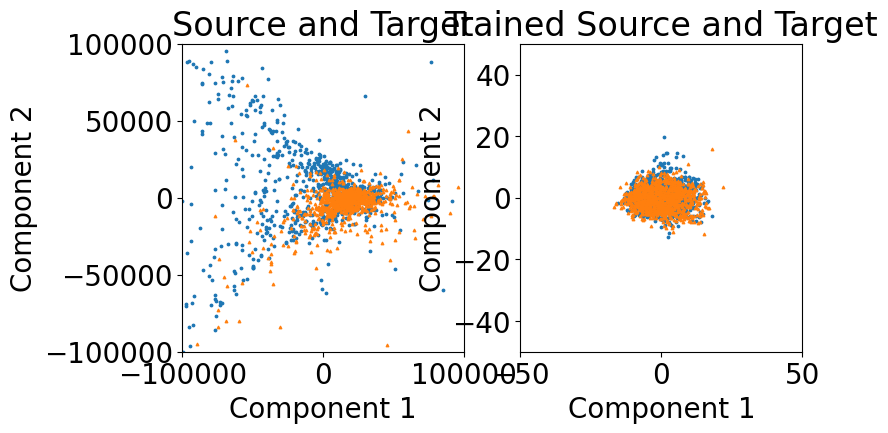

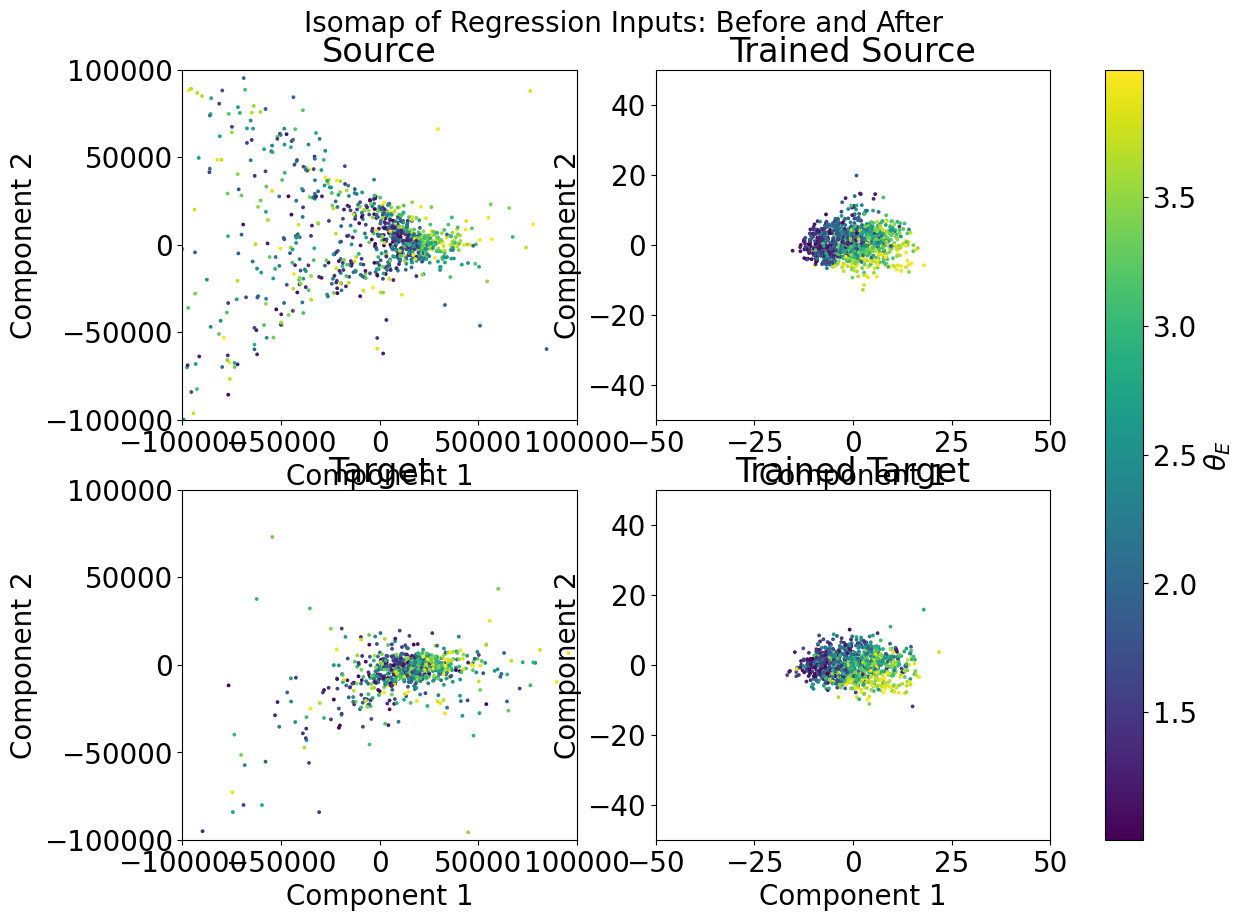

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Trained Source and Target'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object),
 <Figure size 1400x1000 with 5 Axes>,
 array([[<Axes: title={'center': 'Source'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Source'}, xlabel='Component 1', ylabel='Component 2'>],
        [<Axes: title={'center': 'Target'}, xlabel='Component 1', ylabel='Component 2'>,
         <Axes: title={'center': 'Trained Target'}, xlabel='Component 1', ylabel='Component 2'>]],
       dtype=object))

In [110]:
show_isomaps(source_iso, target_iso, trained_source_iso, trained_target_iso, source_labels, target_labels, mod_name, stats["epoch_no"], 100000, 50)

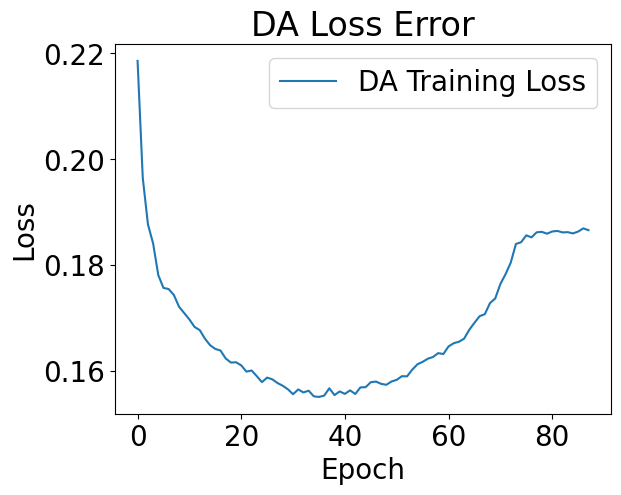

In [25]:
# Classifier
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

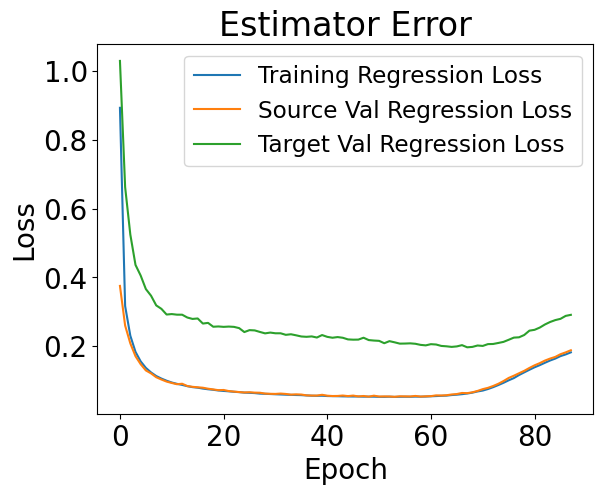

In [26]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

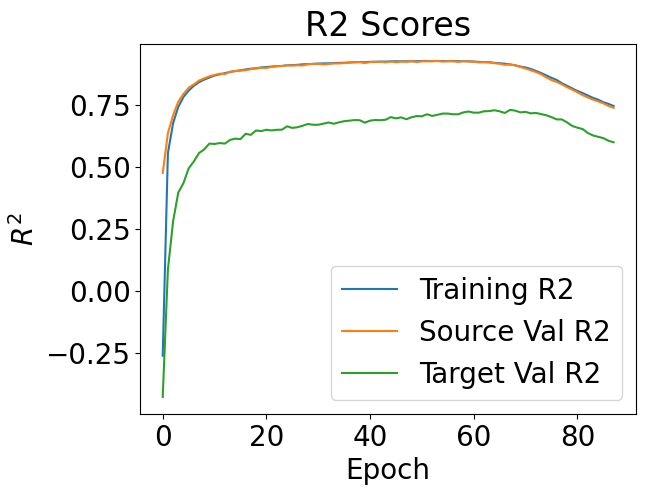

In [27]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()

Source R2 Score is 0.9147


Text(0.5, 1.0, 'MMD | Source | R2: 0.915')

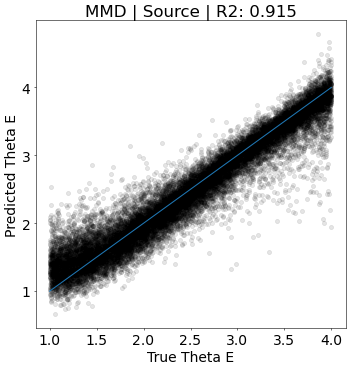

In [28]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(1, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.7272


Text(0.5, 1.0, 'MMD | Target | R2: 0.727')

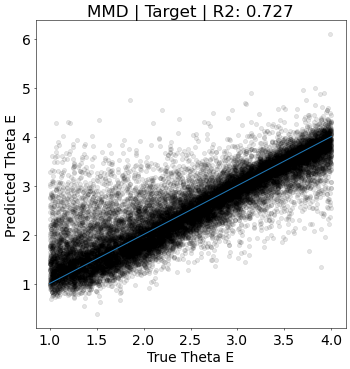

In [46]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(1, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))

In [56]:
X.shape

torch.Size([32, 3, 45, 45])

In [58]:
preds = np.array([])
true = np.array([])
imgs = None

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        if imgs is None:
            imgs = X
        else: 
            imgs =  np.concatenate((imgs, X), axis=0)
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

In [64]:
preds.shape

(20000,)

In [63]:
true.shape

(20000,)

In [62]:
imgs.shape

(20000, 3, 45, 45)

In [101]:
idx = (true < 100)

In [80]:
preds

array([1.30214167, 2.98077202, 2.00425458, ..., 0.95970899, 3.07219529,
       2.18891573])

In [81]:
true

array([1.69164467, 3.9343679 , 2.13911223, ..., 1.52133608, 2.09088802,
       2.36884522])

3.9343678951263428
2.980772018432617


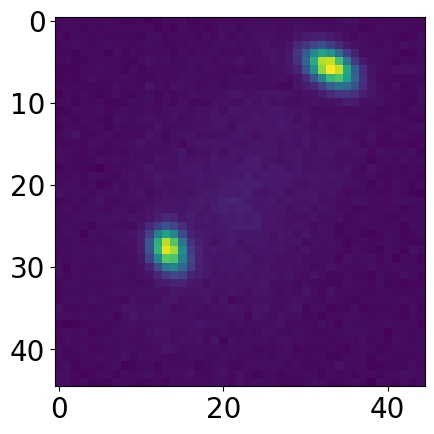

In [82]:
i = 0
b = 0
plt.imshow(imgs[idx][i, b, :, :])
print(true[idx][0])
print(preds[idx][0])

1.5328584909439087
1.4622739553451538


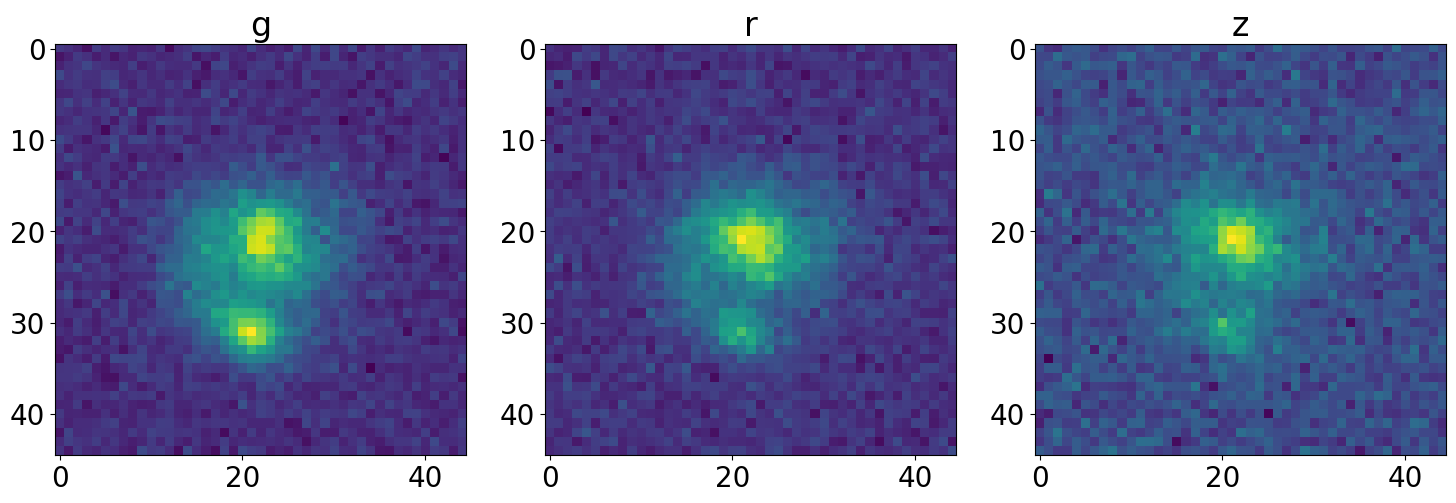

In [103]:
i = 20
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(imgs[idx][i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(imgs[idx][i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(imgs[idx][i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

print(true[idx][i])
print(preds[idx][i])
# Show the plot
plt.show()

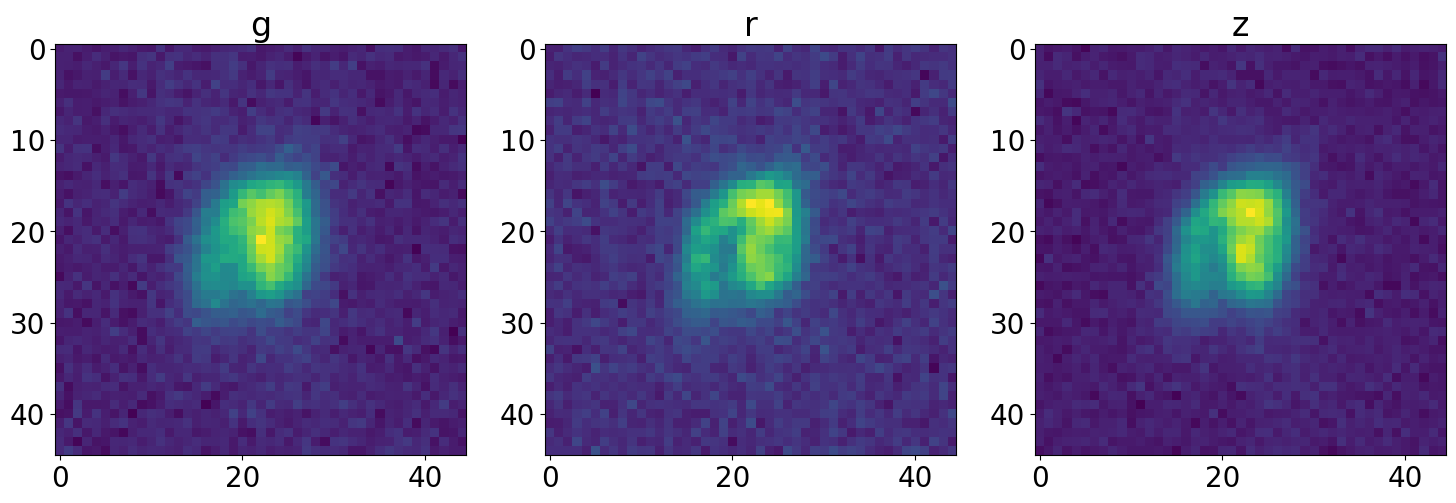

In [105]:
i = 16
# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
axs[0].imshow(source_data[i, 0, :, :])
axs[0].set_title('g')

# Second subplot
axs[1].imshow(source_data[i, 1, :, :])
axs[1].set_title('r')

# Third subplot
axs[2].imshow(source_data[i, 2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()